# ADS1002 TUE G3 PROJECT: Forecasting Sales

### Importing Libraries

In [53]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
warnings.filterwarnings("ignore")

### Data Loading

In [11]:
# Read the CSV files into DataFrames
rossmann_store = pd.read_csv('Rossmann_store.csv')
rossmann_train = pd.read_csv('Rossmann_train.csv', dtype={'StateHoliday': str})

In [12]:
print("\nRossman Store DataFrame:")
rossmann_store.head()


Rossman Store DataFrame:


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
rossmann_store.shape

(1115, 10)

In [14]:
rossmann_store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [23]:
print("\nRossman Train DataFrame:")
rossmann_train.head()


Rossman Train DataFrame:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [24]:
rossmann_train.shape

(1017209, 9)

In [25]:
rossmann_train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

### Data Integration

In [26]:
# Merge "rossmann_train" and "rossmann_store" DataFrames
rossmann = pd.merge(rossmann_train, rossmann_store, on='Store', how='inner')

# Convert Date to datetime format and Create a new column with the name of the day
rossmann['Date'] = pd.to_datetime(rossmann['Date']) 
rossmann['DayOfWeekName'] = rossmann['Date'].dt.day_name()
rossmann.set_index('Date', inplace=True)

In [27]:
print("\nMerged Rossmann DataFrame:")
rossmann.head()


Merged Rossmann DataFrame:


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeekName
Date,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,Friday
2015-07-30,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,Thursday
2015-07-29,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,Wednesday
2015-07-28,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,Tuesday
2015-07-27,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,Monday


In [28]:
rossmann.shape

(1017209, 18)

In [29]:
rossmann.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeekName                 object
dtype: object

### Taking top 20% of Sales

In [30]:
# Find top 20 percentile value of sales
_80th_percentile = rossmann['Sales'].quantile(0.80)

'''Filter the dataframe to include only rows where sales are 
    greater or equal to the 80th percentile value''' 
top_20 = (rossmann[rossmann['Sales']>= _80th_percentile])

In [31]:
top_20.shape

(203460, 18)

## Cleaning Missing Values

In [32]:
top_20.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance             300
CompetitionOpenSinceMonth     61991
CompetitionOpenSinceYear      61991
Promo2                            0
Promo2SinceWeek              119659
Promo2SinceYear              119659
PromoInterval                119659
DayOfWeekName                     0
dtype: int64

In [33]:
rossmann.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
DayOfWeekName                     0
dtype: int64

In [34]:
top_20_clean = top_20.copy()
rossmann_clean = rossmann.copy()

### Investigating stores that have 'CompetitionDistance' missing values

In [35]:
top_20[top_20['CompetitionDistance'].isnull()]['Store'].unique()

array([291, 622, 879])

In [36]:
rossmann[rossmann['CompetitionDistance'].isnull()]['Store'].unique()

array([291, 622, 879])

In [42]:
top_20[top_20['Store']==291].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,297.0,297.000,297.000,297.000,297.0,297.000,297.000,0.0,0.0,0.0,297.0,0.0,0.0
mean,291.0,2.761,10629.801,1048.643,1.0,0.916,0.192,NaN,NaN,NaN,0.0,NaN,NaN
std,0.0,1.466,2117.617,166.095,0.0,0.278,0.394,NaN,NaN,NaN,0.0,NaN,NaN
min,291.0,1.000,8464.000,839.000,1.0,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
25%,291.0,1.000,8958.000,920.000,1.0,1.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
50%,291.0,2.000,9897.000,995.000,1.0,1.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
75%,291.0,4.000,11921.000,1155.000,1.0,1.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
max,291.0,6.000,21872.000,1847.000,1.0,1.000,1.000,NaN,NaN,NaN,0.0,NaN,NaN


In [43]:
rossmann[rossmann['Store']==291].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,942.0,942.000,942.000,942.000,942.000,942.000,942.000,0.0,0.0,0.0,942.0,0.0,0.0
mean,291.0,3.998,6643.281,695.831,0.828,0.382,0.183,NaN,NaN,NaN,0.0,NaN,NaN
std,0.0,1.998,3862.815,376.349,0.378,0.486,0.387,NaN,NaN,NaN,0.0,NaN,NaN
min,291.0,1.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
25%,291.0,2.000,4673.500,513.000,1.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
50%,291.0,4.000,7006.000,789.500,1.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
75%,291.0,6.000,8867.250,917.750,1.000,1.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
max,291.0,7.000,21872.000,1847.000,1.000,1.000,1.000,NaN,NaN,NaN,0.0,NaN,NaN


In [44]:
top_20[top_20['Store']==622].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,2.0,2.0,2.000,2.000,2.0,2.000,2.000,0.0,0.0,0.0,2.0,0.0,0.0
mean,622.0,1.0,9009.000,788.500,1.0,0.500,0.500,NaN,NaN,NaN,0.0,NaN,NaN
std,0.0,0.0,472.347,187.383,0.0,0.707,0.707,NaN,NaN,NaN,0.0,NaN,NaN
min,622.0,1.0,8675.000,656.000,1.0,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
25%,622.0,1.0,8842.000,722.250,1.0,0.250,0.250,NaN,NaN,NaN,0.0,NaN,NaN
50%,622.0,1.0,9009.000,788.500,1.0,0.500,0.500,NaN,NaN,NaN,0.0,NaN,NaN
75%,622.0,1.0,9176.000,854.750,1.0,0.750,0.750,NaN,NaN,NaN,0.0,NaN,NaN
max,622.0,1.0,9343.000,921.000,1.0,1.000,1.000,NaN,NaN,NaN,0.0,NaN,NaN


In [45]:
rossmann[rossmann['Store']==622].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,942.0,942.000,942.000,942.000,942.000,942.000,942.000,0.0,0.0,0.0,942.0,0.0,0.0
mean,622.0,3.998,3593.718,357.877,0.832,0.382,0.169,NaN,NaN,NaN,0.0,NaN,NaN
std,0.0,1.998,1925.818,179.990,0.374,0.486,0.375,NaN,NaN,NaN,0.0,NaN,NaN
min,622.0,1.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
25%,622.0,2.000,2751.000,287.000,1.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
50%,622.0,4.000,3969.500,419.000,1.000,0.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
75%,622.0,6.000,4787.750,469.000,1.000,1.000,0.000,NaN,NaN,NaN,0.0,NaN,NaN
max,622.0,7.000,9343.000,921.000,1.000,1.000,1.000,NaN,NaN,NaN,0.0,NaN,NaN


In [46]:
top_20[top_20['Store']==879].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
mean,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0
25%,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0
50%,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0
75%,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0
max,879.0,1.0,8464.0,579.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0,5.0,2013.0


In [47]:
rossmann[rossmann['Store']==879].describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,758.0,758.000,758.000,758.000,758.000,758.000,758.000,0.0,0.0,0.0,758.0,758.0,758.0
mean,879.0,4.001,3087.831,285.009,0.821,0.377,0.164,NaN,NaN,NaN,1.0,5.0,2013.0
std,0.0,1.999,1712.393,145.515,0.384,0.485,0.370,NaN,NaN,NaN,0.0,0.0,0.0
min,879.0,1.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,1.0,5.0,2013.0
25%,879.0,2.000,2574.750,270.250,1.000,0.000,0.000,NaN,NaN,NaN,1.0,5.0,2013.0
50%,879.0,4.000,3326.500,323.000,1.000,0.000,0.000,NaN,NaN,NaN,1.0,5.0,2013.0
75%,879.0,6.000,4151.250,372.750,1.000,1.000,0.000,NaN,NaN,NaN,1.0,5.0,2013.0
max,879.0,7.000,8464.000,661.000,1.000,1.000,1.000,NaN,NaN,NaN,1.0,5.0,2013.0


In [48]:
top_20['CompetitionDistance'].describe().round(3)

count    203160.000
mean       5199.038
std        7805.721
min          20.000
25%         460.000
50%        1920.000
75%        6480.000
max       75860.000
Name: CompetitionDistance, dtype: float64

In [49]:
rossmann['CompetitionDistance'].describe().round(3)

count    1014567.000
mean        5430.086
std         7715.324
min           20.000
25%          710.000
50%         2330.000
75%         6890.000
max        75860.000
Name: CompetitionDistance, dtype: float64

* Three stores with missing "CompetitionDistance" data also lack entries for "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear". This suggests that the data omissions are not mere oversights. It's possible that Rossmann didn't document competitors situated beyond 75,860 meters, considering such distances might categorize them in a distinct economic zone with negligible influence on sales. Given the limited instances of these missing values and the intricate context, our team opted against imputing the competition distance values. This complexity is further compounded by the fact that the distribution of Rossmann stores is influenced by the number and size of cities in various countries. Such a distribution has a direct bearing on sales and warrants meticulous evaluation, making straightforward imputation inadvisable.

### Drop Missing Values of 'CompetitionDistance'

In [50]:
top_20_clean.dropna(subset ='CompetitionDistance',inplace = True)
rossmann_clean.dropna(subset ='CompetitionDistance',inplace = True)

### Investigating missing values for 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear'

In [51]:
top_20_clean.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth     61691
CompetitionOpenSinceYear      61691
Promo2                            0
Promo2SinceWeek              119360
Promo2SinceYear              119360
PromoInterval                119360
DayOfWeekName                     0
dtype: int64

In [52]:
rossmann_clean.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    320706
CompetitionOpenSinceYear     320706
Promo2                            0
Promo2SinceWeek              506147
Promo2SinceYear              506147
PromoInterval                506147
DayOfWeekName                     0
dtype: int64

In [54]:
top_20_clean['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

In [55]:
rossmann_clean['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

* Rossmann was founded in 1972; however, we have data for "CompetitionOpenSinceYear" that are 1900 and 1961. We might consider these data as outliers due to misentry, but there's also a possibility that other competing stores opened before the Rossmann stores and that Rossmann kept records of these after investigation. Overall, without further information to fully justify dropping these data, we've decided to retain them.

In [56]:
top_20_clean['CompetitionOpenSinceMonth'].unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

In [57]:
rossmann_clean['CompetitionOpenSinceMonth'].unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

* No abnormalities in the 'CompetitionOpenSinceMonth' data.

### Checking if the stores with missing 'CompetitionOpenSinceYear' are the same as those with missing 'CompetitionOpenSinceMonth' 

In [479]:
check = top_20_clean[top_20_clean['CompetitionOpenSinceYear'].isnull()]['Store']==top_20_clean[top_20_clean['CompetitionOpenSinceMonth'].isnull()]['Store']
check.describe()

count     61691
unique        1
top        True
freq      61691
Name: Store, dtype: object

In [480]:
check = rossmann_clean[rossmann_clean['CompetitionOpenSinceYear'].isnull()]['Store']==rossmann_clean[rossmann_clean['CompetitionOpenSinceMonth'].isnull()]['Store']
check.describe()

count     320706
unique         1
top         True
freq      320706
Name: Store, dtype: object

* We can confirm that the missing values for "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" occur simultaneously. Therefore, the most probable reasons for the absence of these two data points are that the competing store existed before the store was established, or there was an omission in data recording. Even though these data sets have some missing columns, they contain meaningful information in other columns, so we've decided to keep them.

### Investigating missing values for 'Promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval'

In [481]:
top_20_clean.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth     61691
CompetitionOpenSinceYear      61691
Promo2                            0
Promo2SinceWeek              119360
Promo2SinceYear              119360
PromoInterval                119360
DayOfWeekName                     0
dtype: int64

In [486]:
top_20_clean.notnull().sum()

Store                        203160
DayOfWeek                    203160
Sales                        203160
Customers                    203160
Open                         203160
Promo                        203160
StateHoliday                 203160
SchoolHoliday                203160
StoreType                    203160
Assortment                   203160
CompetitionDistance          203160
CompetitionOpenSinceMonth    141469
CompetitionOpenSinceYear     141469
Promo2                       203160
Promo2SinceWeek               83800
Promo2SinceYear               83800
PromoInterval                 83800
DayOfWeekName                203160
dtype: int64

In [487]:
rossmann_clean.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    320706
CompetitionOpenSinceYear     320706
Promo2                            0
Promo2SinceWeek              506147
Promo2SinceYear              506147
PromoInterval                506147
DayOfWeekName                     0
dtype: int64

In [488]:
rossmann_clean.notnull().sum()

Store                        1014567
DayOfWeek                    1014567
Sales                        1014567
Customers                    1014567
Open                         1014567
Promo                        1014567
StateHoliday                 1014567
SchoolHoliday                1014567
StoreType                    1014567
Assortment                   1014567
CompetitionDistance          1014567
CompetitionOpenSinceMonth     693861
CompetitionOpenSinceYear      693861
Promo2                       1014567
Promo2SinceWeek               508420
Promo2SinceYear               508420
PromoInterval                 508420
DayOfWeekName                1014567
dtype: int64

In [60]:
# Define a function to generate a confusion matrix based on given conditions.
def generate_confusion_matrix(promo2_condition, target_condition):
    TP = sum(promo2_condition & target_condition)
    TN = sum(~promo2_condition & ~target_condition)
    FP = sum(~promo2_condition & target_condition)
    FN = sum(promo2_condition & ~target_condition)

    # Create a DataFrame to represent the confusion matrix
    matrix = pd.DataFrame({
        'Promo2 Yes': [TP, FN],
        'Promo2 No': [FP, TN]
    }, index=[f'{target_condition.name} Not Null', f'{target_condition.name} Null'])
    
    return matrix

# Define a function to display multiple DataFrames side by side
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str))

    
# Define Promo2 condition
promo2_yes = top_20_clean['Promo2'] == 1

# Generate confusion matrices for different columns
matrix_year = generate_confusion_matrix(promo2_yes, top_20_clean['Promo2SinceYear'].notnull())
matrix_week = generate_confusion_matrix(promo2_yes, top_20_clean['Promo2SinceWeek'].notnull())
matrix_interval = generate_confusion_matrix(promo2_yes, top_20_clean['PromoInterval'].notnull())

# Display the confusion matrices
display_side_by_side(matrix_year, matrix_week, matrix_interval)

,Promo2 Yes,Promo2 No
Promo2SinceYear Not Null,83800,0
Promo2SinceYear Null,0,119360
,Promo2 Yes,Promo2 No
Promo2SinceWeek Not Null,83800,0
Promo2SinceWeek Null,0,119360
,Promo2 Yes,Promo2 No
PromoInterval Not Null,83800,0
PromoInterval Null,0,119360


In [61]:
# Define a function to generate a confusion matrix based on given conditions.
def generate_confusion_matrix(promo2_condition, target_condition):
    TP = sum(promo2_condition & target_condition)
    TN = sum(~promo2_condition & ~target_condition)
    FP = sum(~promo2_condition & target_condition)
    FN = sum(promo2_condition & ~target_condition)

    # Create a DataFrame to represent the confusion matrix
    matrix = pd.DataFrame({
        'Promo2 Yes': [TP, FN],
        'Promo2 No': [FP, TN]
    }, index=[f'{target_condition.name} Not Null', f'{target_condition.name} Null'])
    
    return matrix

# Define a function to display multiple DataFrames side by side
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str))

    
# Define Promo2 condition
promo2_yes = rossmann_clean['Promo2'] == 1

# Generate confusion matrices for different columns
matrix_year = generate_confusion_matrix(promo2_yes, rossmann_clean['Promo2SinceYear'].notnull())
matrix_week = generate_confusion_matrix(promo2_yes, rossmann_clean['Promo2SinceWeek'].notnull())
matrix_interval = generate_confusion_matrix(promo2_yes, rossmann_clean['PromoInterval'].notnull())

# Display the confusion matrices
display_side_by_side(matrix_year, matrix_week, matrix_interval)

,Promo2 Yes,Promo2 No
Promo2SinceYear Not Null,508420,0
Promo2SinceYear Null,0,506147
,Promo2 Yes,Promo2 No
Promo2SinceWeek Not Null,508420,0
Promo2SinceWeek Null,0,506147
,Promo2 Yes,Promo2 No
PromoInterval Not Null,508420,0
PromoInterval Null,0,506147


* The presence of null values occurs when promotion 2 is not happening. Thus, having these missing values is not an issue.

### Description of Cleaned DataFrames

In [62]:
top_20_clean.describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,203160.000,203160.000,203160.000,203160.000,203160.0,203160.000,203160.000,203160.000,141469.000,141469.000,203160.000,83800.000,83800.000
mean,565.191,3.067,11210.718,1200.116,1.0,0.712,0.215,5199.038,7.030,2008.674,0.412,25.059,2011.684
std,313.504,1.752,2909.469,526.850,0.0,0.453,0.411,7805.721,3.147,6.942,0.492,14.123,1.772
min,1.000,1.000,8461.000,216.000,1.0,0.000,0.000,20.000,1.000,1900.000,0.000,1.000,2009.000
25%,316.000,1.000,9227.000,870.000,1.0,0.000,0.000,460.000,4.000,2006.000,0.000,13.000,2010.000
50%,546.000,3.000,10288.000,1066.000,1.0,1.000,0.000,1920.000,7.000,2010.000,0.000,22.000,2011.000
75%,826.000,5.000,12137.000,1336.000,1.0,1.000,0.000,6480.000,10.000,2013.000,1.000,40.000,2013.000
max,1115.000,7.000,41551.000,7388.000,1.0,1.000,1.000,75860.000,12.000,2015.000,1.000,50.000,2015.000


In [63]:
rossmann_clean.describe().round(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1014567.00,1014567.000,1014567.000,1014567.000,1014567.000,1014567.000,1014567.000,1014567.000,693861.000,693861.000,1014567.000,508420.000,508420.000
mean,558.38,3.998,5777.043,633.603,0.830,0.382,0.179,5430.086,7.223,2008.690,0.501,23.296,2011.751
std,322.10,1.997,3851.045,464.648,0.376,0.486,0.383,7715.324,3.212,5.993,0.500,14.089,1.663
min,1.00,1.000,0.000,0.000,0.000,0.000,0.000,20.000,1.000,1900.000,0.000,1.000,2009.000
25%,280.00,2.000,3732.000,405.000,1.000,0.000,0.000,710.000,4.000,2006.000,0.000,13.000,2011.000
50%,558.00,4.000,5748.000,610.000,1.000,0.000,0.000,2330.000,8.000,2010.000,1.000,22.000,2012.000
75%,837.00,6.000,7859.000,837.000,1.000,1.000,0.000,6890.000,10.000,2013.000,1.000,37.000,2013.000
max,1115.00,7.000,41551.000,7388.000,1.000,1.000,1.000,75860.000,12.000,2015.000,1.000,50.000,2015.000


## Exploratory Data Analysis

### Sales

In [66]:
rossmann['Sales'].describe().round(2)

count    1017209.00
mean        5773.82
std         3849.93
min            0.00
25%         3727.00
50%         5744.00
75%         7856.00
max        41551.00
Name: Sales, dtype: float64

In [67]:
top_20['Sales'].describe().round(2)

count    203460.00
mean      11209.83
std        2908.54
min        8461.00
25%        9226.00
50%       10287.00
75%       12136.00
max       41551.00
Name: Sales, dtype: float64

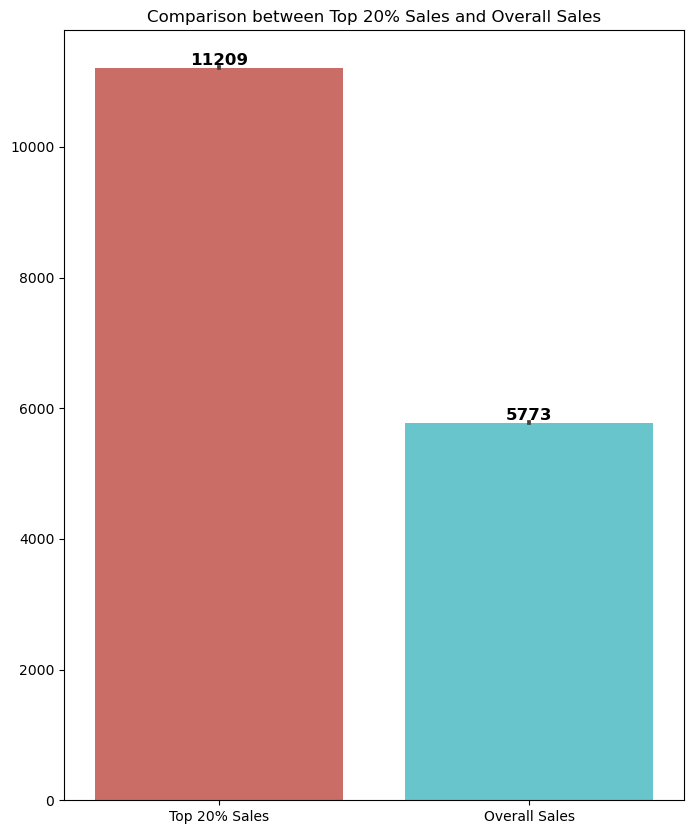

In [87]:
colors = sns.color_palette('hls', 2)

# Box plots to compare between overall sales and top 20% sales
plt.figure(figsize=(8,10))
ax = sns.barplot(data=[top_20['Sales'],rossmann['Sales']], palette=colors)

# Display figures on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom',weight='bold')

# Setting labels
plt.xticks([0, 1], ['Top 20% Sales', 'Overall Sales'])
plt.title('Comparison between Top 20% Sales and Overall Sales')
plt.show()

### Regression Plot (Sales vs Customers)

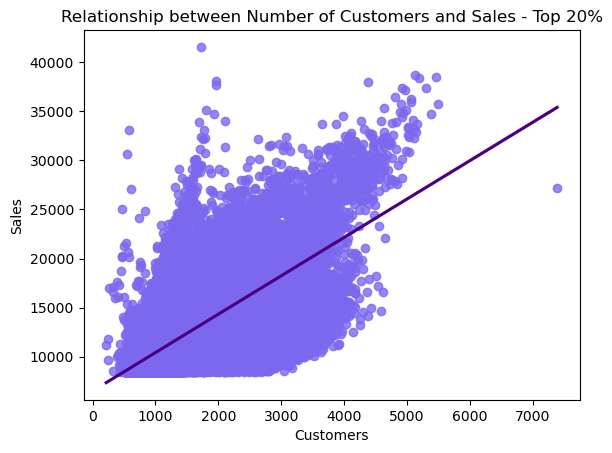

In [76]:
sns.regplot(x=top_20_clean['Customers'], y=top_20_clean['Sales'],color='mediumslateblue', line_kws={'color': 'indigo'})
plt.title('Relationship between Number of Customers and Sales - Top 20%');

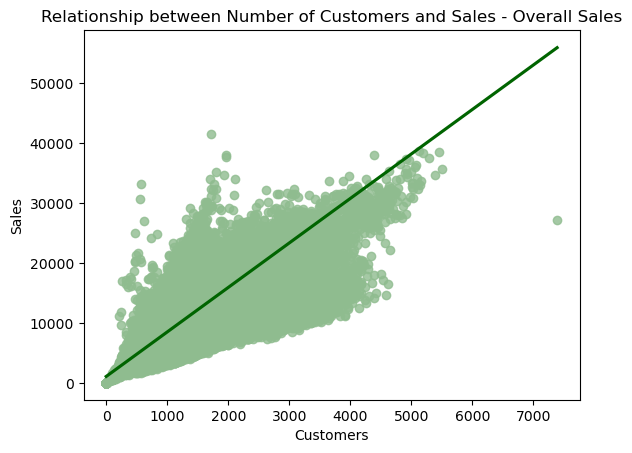

In [88]:
sns.regplot(x=rossmann_clean['Customers'], y=rossmann_clean['Sales'],color='darkseagreen', line_kws={'color': 'darkgreen'})
plt.title('Relationship between Number of Customers and Sales - Overall Sales');

* There is a clear linear relation between customers and sales.

### Assortment

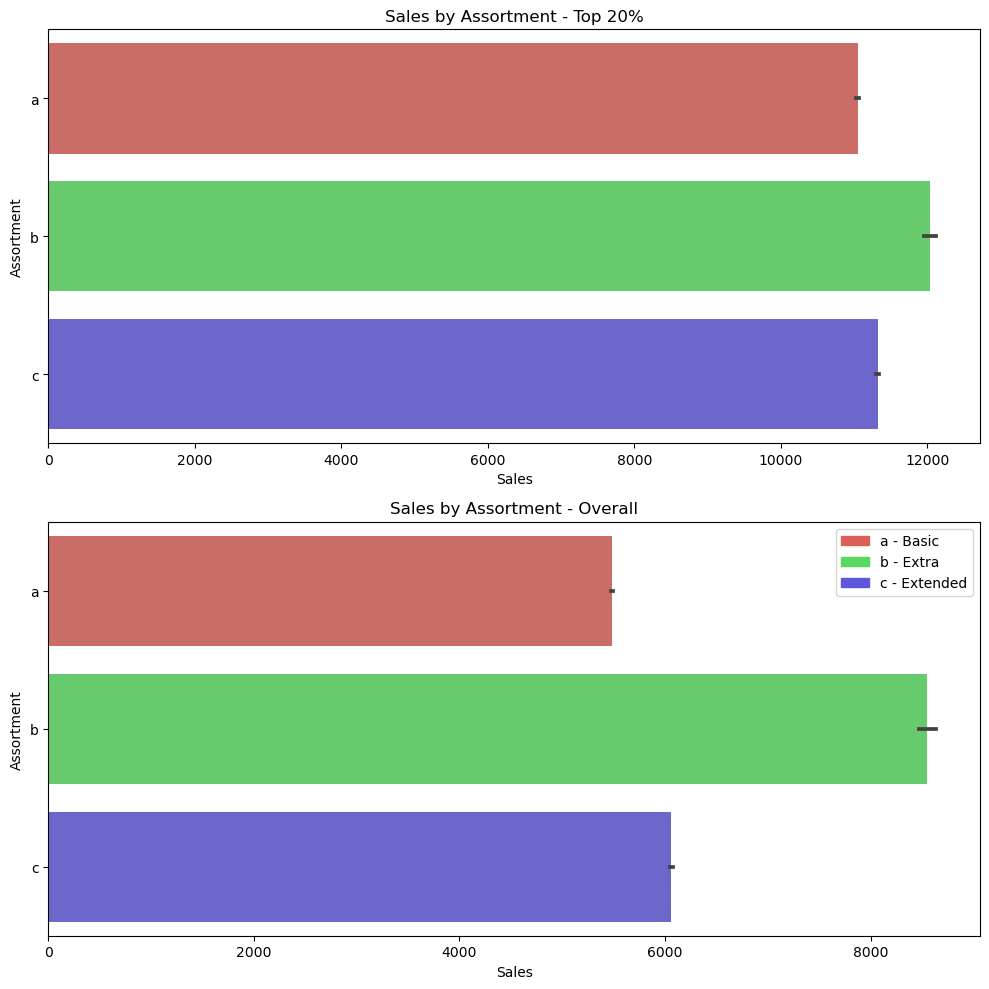

In [78]:
# Define the order of assortments for consistent visualization
order_assortment = ['a', 'b', 'c']

# Set a color palette with 3 distinct colors for the assortments
colors = sns.color_palette('hls', 3)

# Create a new figure with specified size
plt.figure(figsize=(10, 10))

# First subplot: Barplot for Sales by Assortment in the Top 20% dataset
plt.subplot(2, 1, 1)  
sns.barplot(data=top_20_clean, x='Sales', y='Assortment', palette=colors, order=order_assortment)
plt.xlabel('Sales')
plt.ylabel('Assortment')
plt.title('Sales by Assortment - Top 20%')

# Second subplot: Barplot for Sales by Assortment in the entire dataset
plt.subplot(2, 1, 2)
sns.barplot(data=rossmann_clean, x='Sales', y='Assortment', palette=colors, order=order_assortment)
plt.xlabel('Sales')
plt.ylabel('Assortment')
plt.title('Sales by Assortment - Overall')

# Add a legend to the figure to help identify each assortment type
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(['a - Basic', 'b - Extra', 'c - Extended'])]
plt.legend(handles=legend_patches, loc='upper right')

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

* Assortment b has the highest sales among other types.

### Store Type

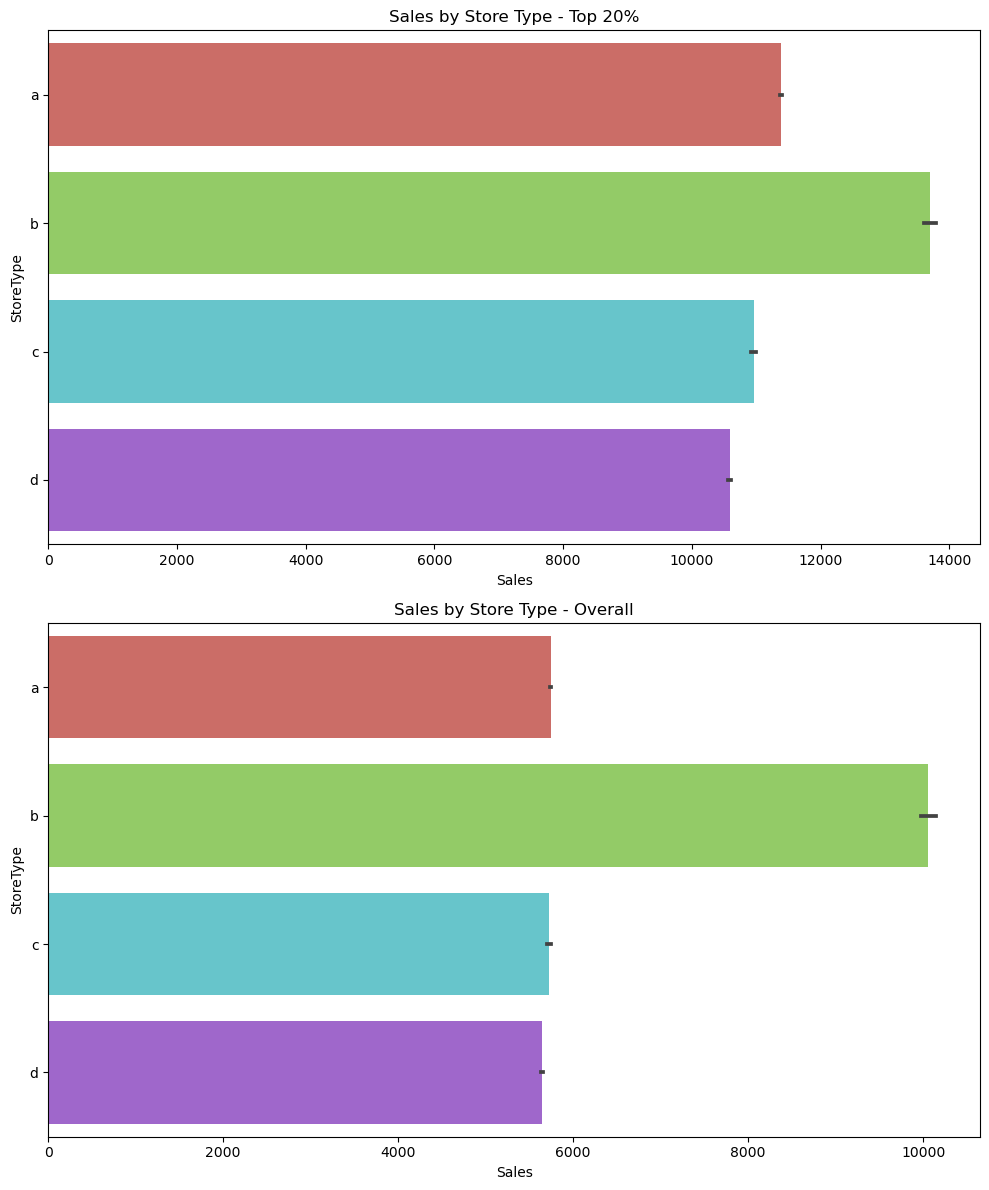

In [79]:
# Define the order of store types for consistent visualization
order_storetype = ['a', 'b', 'c', 'd']

# Set a color palette with 4 distinct colors for the store types
colors = sns.color_palette('hls', 4)

# Create a new figure with specified size
plt.figure(figsize=(10, 12))

# First subplot: Barplot for Sales by Store Type in the Top 20% dataset
plt.subplot(2, 1, 1)
sns.barplot(data=top_20_clean, x='Sales', y='StoreType', palette=colors, order=order_storetype)
plt.xlabel('Sales')
plt.ylabel('StoreType')
plt.title('Sales by Store Type - Top 20%')

# Second subplot: Barplot for Sales by Store Type in the entire dataset
plt.subplot(2, 1, 2)
sns.barplot(data=rossmann_clean, x='Sales', y='StoreType', palette=colors, order=order_storetype)
plt.xlabel('Sales')
plt.ylabel('StoreType')
plt.title('Sales by Store Type - Overall')

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

* Store type b has the highest sales among other types

### Promotions

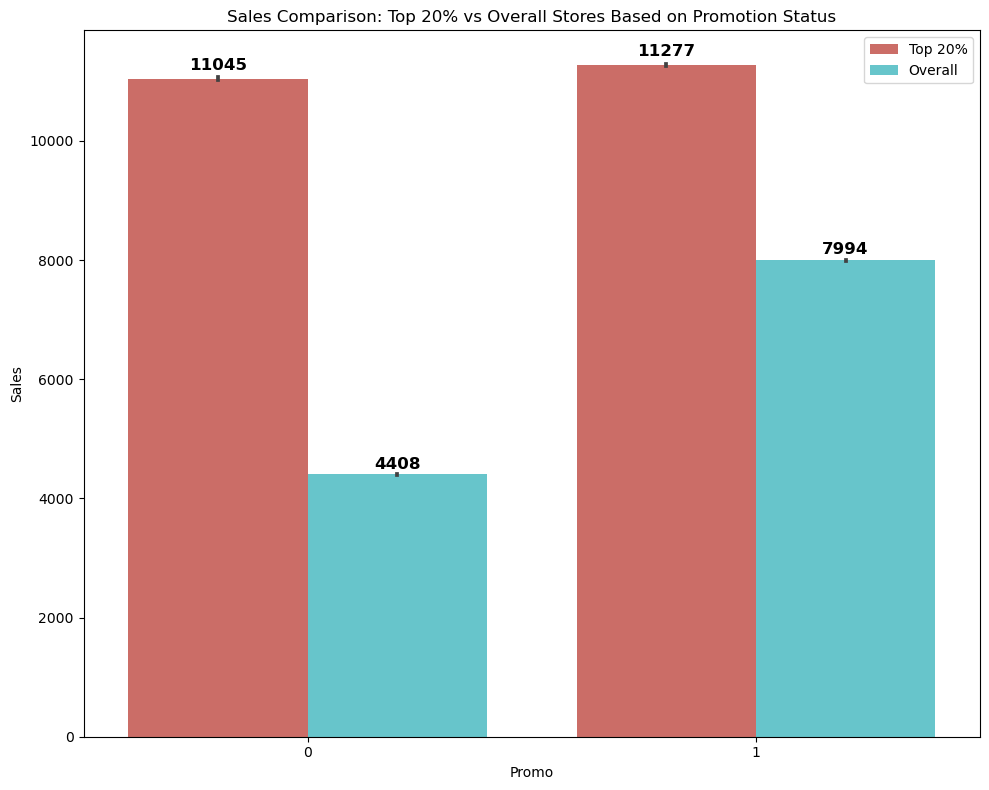

In [81]:
# Add a new column 'source' to each dataframe to distinguish between the top 20% stores and the overall dataset
top_20_clean['source'] = 'Top 20%'
rossmann_clean['source'] = 'Overall'

# Combine the two dataframes into one for visualization
combined_data = pd.concat([top_20_clean, rossmann_clean])

# Set a color palette with 2 distinct colors for the bar plot
colors = sns.color_palette('hls', 2)

# Create a new figure with a specified size
plt.figure(figsize=(10, 8))

# Generate a bar plot comparing Sales based on Promo status, differentiated by the data source (Top 20% vs Overall)
ax = sns.barplot(data=combined_data, x='Promo', y='Sales', hue='source', palette=colors)

# Set the labels and title for the plot
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.title('Sales Comparison: Top 20% vs Overall Stores Based on Promotion Status')

# Annotate each bar with its respective sales value
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom', weight='bold')

# Display the legend to differentiate between Top 20% and Overall
plt.legend()

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

plt.show()

* Holding a promotion shows significant sales increase.

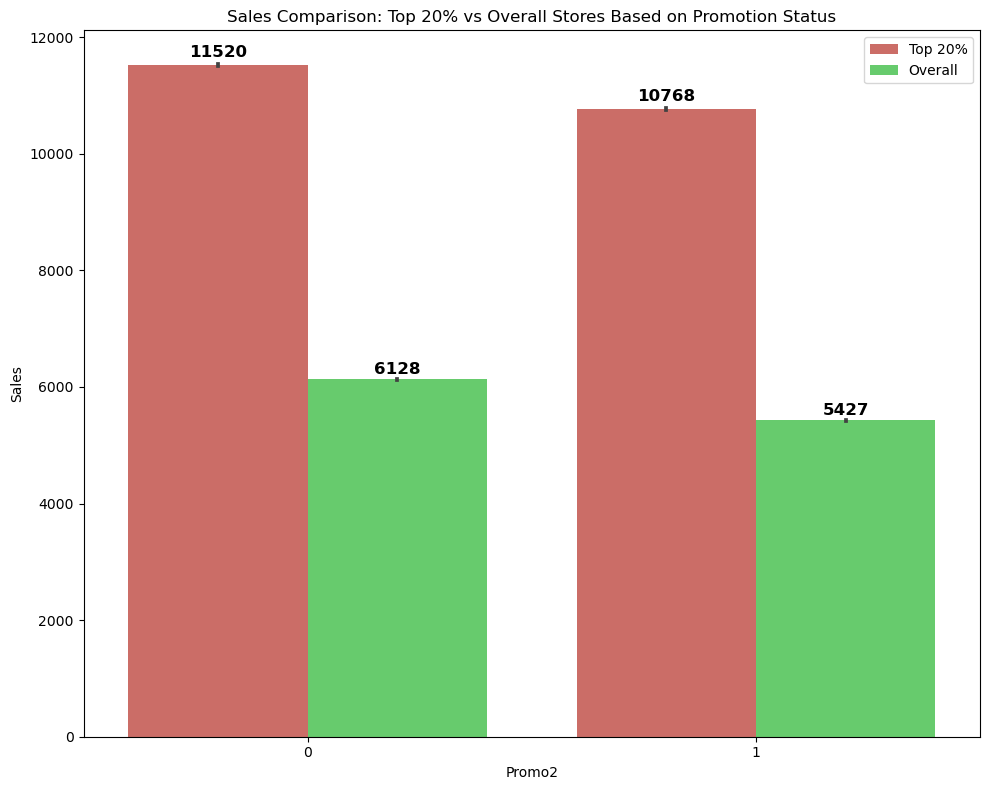

In [90]:
# Combine the two dataframes into a single dataframe for visualization
combined_data = pd.concat([top_20_clean, rossmann_clean])

# Set a color palette with 3 distinct colors for the bar plot
colors = sns.color_palette('hls', 3)

# Create a new figure with specified size
plt.figure(figsize=(10, 8))

# Generate a bar plot comparing Sales based on Promo2 status and differentiate by the data source (Top 20% vs Overall)
ax = sns.barplot(data=combined_data, x='Promo2', y='Sales', hue='source', palette=colors)

# Set the labels and title for the plot
plt.xlabel('Promo2')
plt.ylabel('Sales')
plt.title('Sales Comparison: Top 20% vs Overall Stores Based on Promotion Status')

# Annotate each bar with its corresponding sales value
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom', weight='bold')

# Display the legend to differentiate between Top 20% and Overall
plt.legend()

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

plt.show()

In [56]:
top_20_promo2 = top_20_clean[top_20_clean['Promo2']==1]
top_20_no_promo2 = top_20_clean[top_20_clean['Promo2']==0]

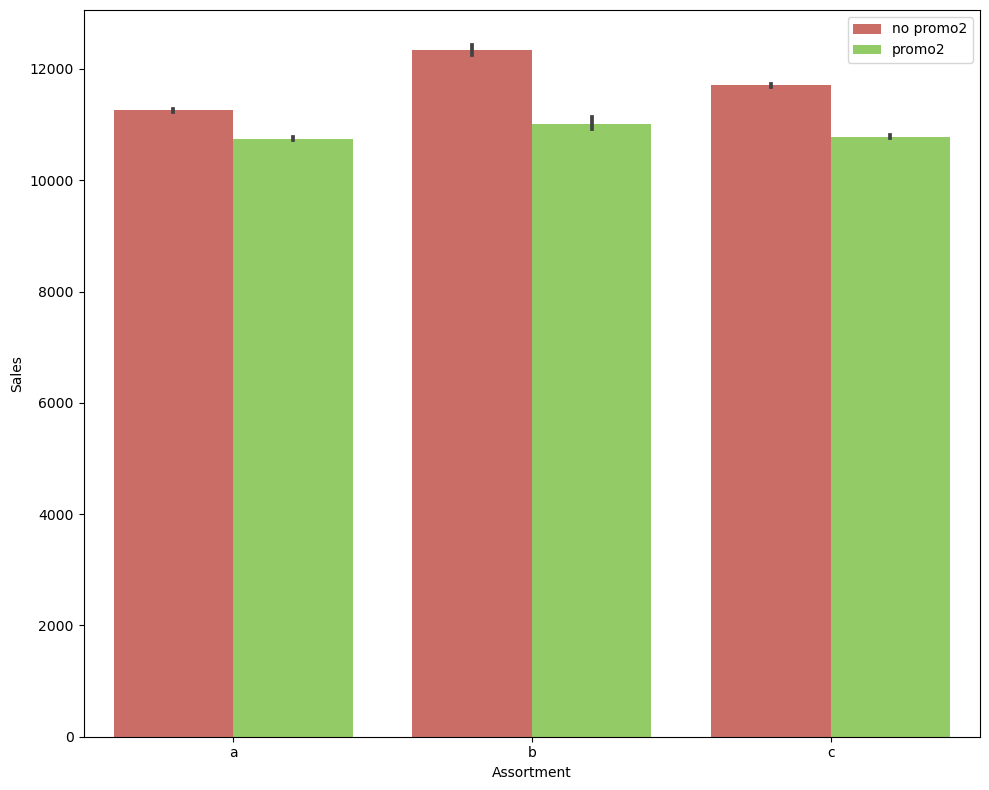

In [57]:
# Add a new column 'source' to each dataframe to differentiate stores with 'promo2' from those without
top_20_promo2['source'] = 'promo2'
top_20_no_promo2['source'] = 'no promo2'

# Define the order of assortment for consistent visualization
order_assortment = ['a', 'b', 'c']

# Combine the two dataframes for visualization purposes
combined_data = pd.concat([top_20_no_promo2, top_20_promo2])

# Define a color palette with 4 distinct colors for the visualization
colors = sns.color_palette('hls', 4)

# Create a new figure with a specified size
plt.figure(figsize=(10, 8))

# Generate a bar plot comparing Sales by Assortment, differentiating by the promo2 status
ax = sns.barplot(data=combined_data, x='Assortment', y='Sales', order=order_assortment, hue='source', palette=colors)

# Set the labels for the plot
plt.xlabel('Assortment')
plt.ylabel('Sales')

# Display a legend to differentiate between stores with 'promo2' and those without
plt.legend()

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

plt.show()

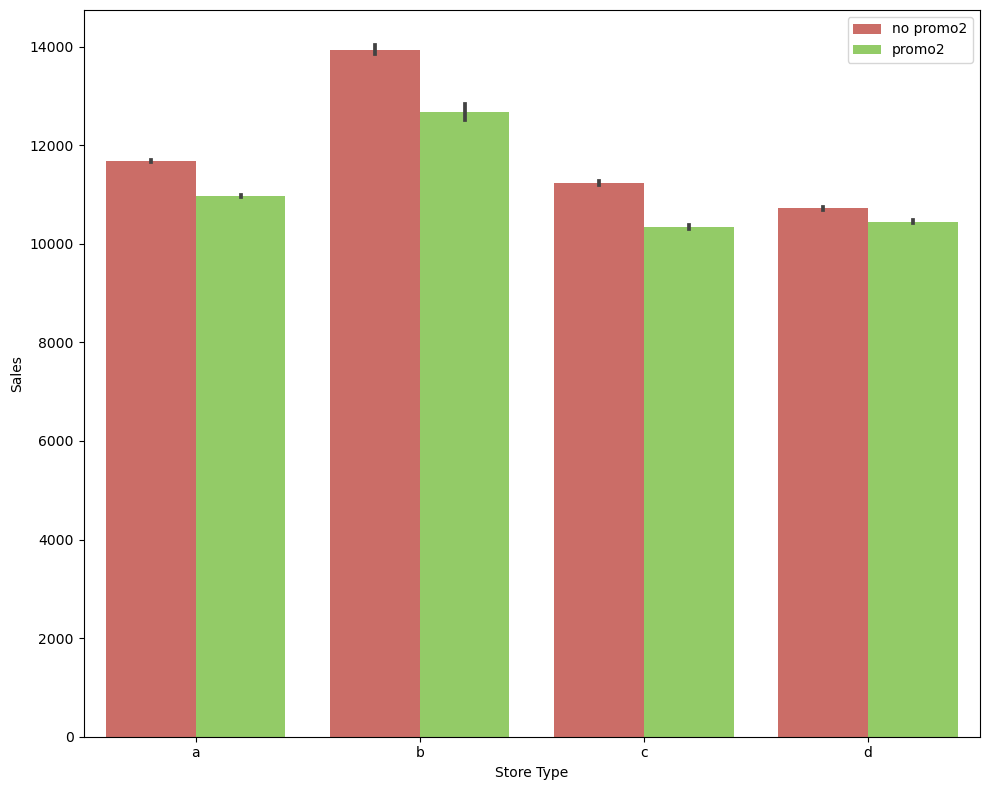

In [58]:
# Add a new column 'source' to each dataframe to differentiate stores with 'promo2' from those without
top_20_promo2['source'] = 'promo2'
top_20_no_promo2['source'] = 'no promo2'

# Define the order of assortment for consistent visualization
order_assortment = ['a', 'b', 'c']

# Combine the two dataframes for visualization purposes
combined_data = pd.concat([top_20_no_promo2, top_20_promo2])

# Define a color palette with 4 distinct colors for the visualization
colors = sns.color_palette('hls', 4)

# Create a new figure with a specified size
plt.figure(figsize=(10, 8))

# Generate a bar plot comparing Sales by Assortment, differentiating by the promo2 status
ax = sns.barplot(data=combined_data, x='Assortment', y='Sales', order=order_assortment, hue='source', palette=colors)

# Set the labels for the plot
plt.xlabel('Assortment')
plt.ylabel('Sales')

# Display a legend to differentiate between stores with 'promo2' and those without
plt.legend()

# Adjust the layout to ensure plots and labels don't overlap
plt.tight_layout()

plt.show()

* In all instances, we observed that sales decrease when there was continuous and consecutive promotion (Promo2) in effect.

### Holidays

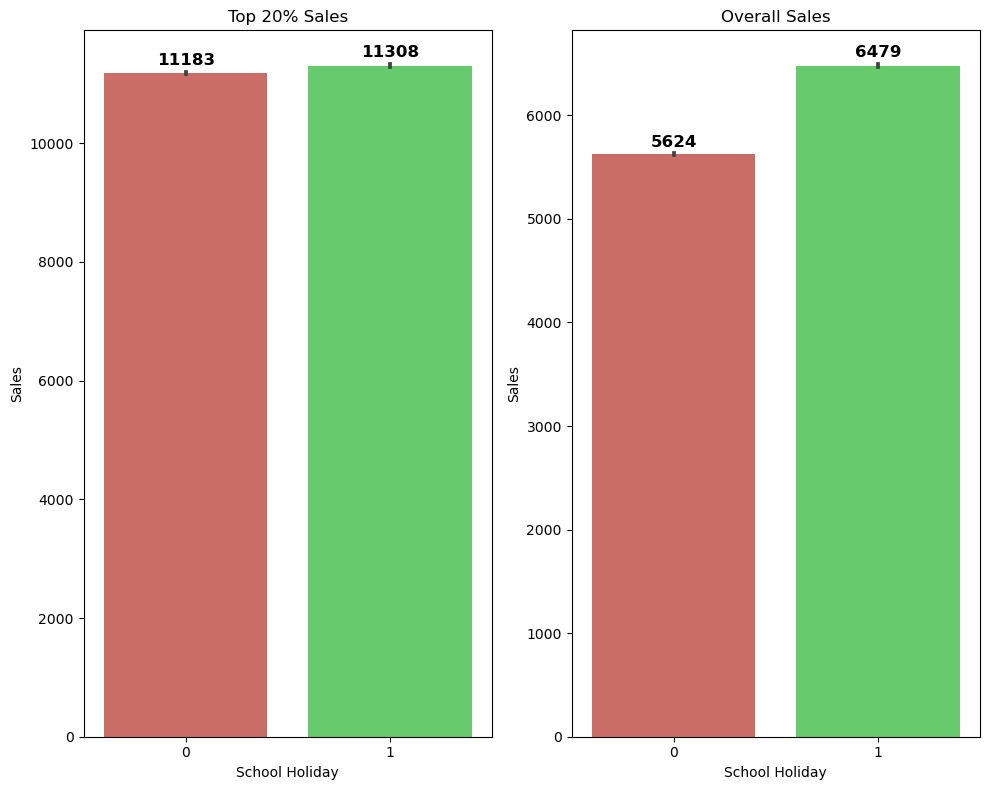

In [91]:
# Define a color palette with three distinct colors
colors = sns.color_palette('hls', 3)

# Initialize a figure with a specified size to plot two subplots side by side
plt.figure(figsize=(10, 8))

# First subplot: Displaying sales data for top 20% stores during school holidays
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=top_20_clean, x='SchoolHoliday', y='Sales', palette=colors)
plt.xlabel('School Holiday')
plt.ylabel('Sales')
plt.title('Top 20% Sales')

# Annotate the bars in the first subplot with their respective values
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom', weight='bold')

# Second subplot: Displaying overall sales data during school holidays
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=rossmann_clean, x='SchoolHoliday', y='Sales', palette=colors)
plt.xlabel('School Holiday')
plt.ylabel('Sales')
plt.title('Overall Sales')

# Annotate the bars in the second subplot with their respective values
for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom', weight='bold')

# Adjust the layout to ensure plots, labels, and titles don't overlap
plt.tight_layout()

* For the top 20% of sales, school holidays don't affect the sales. However, for overall sales, an increase is observed.

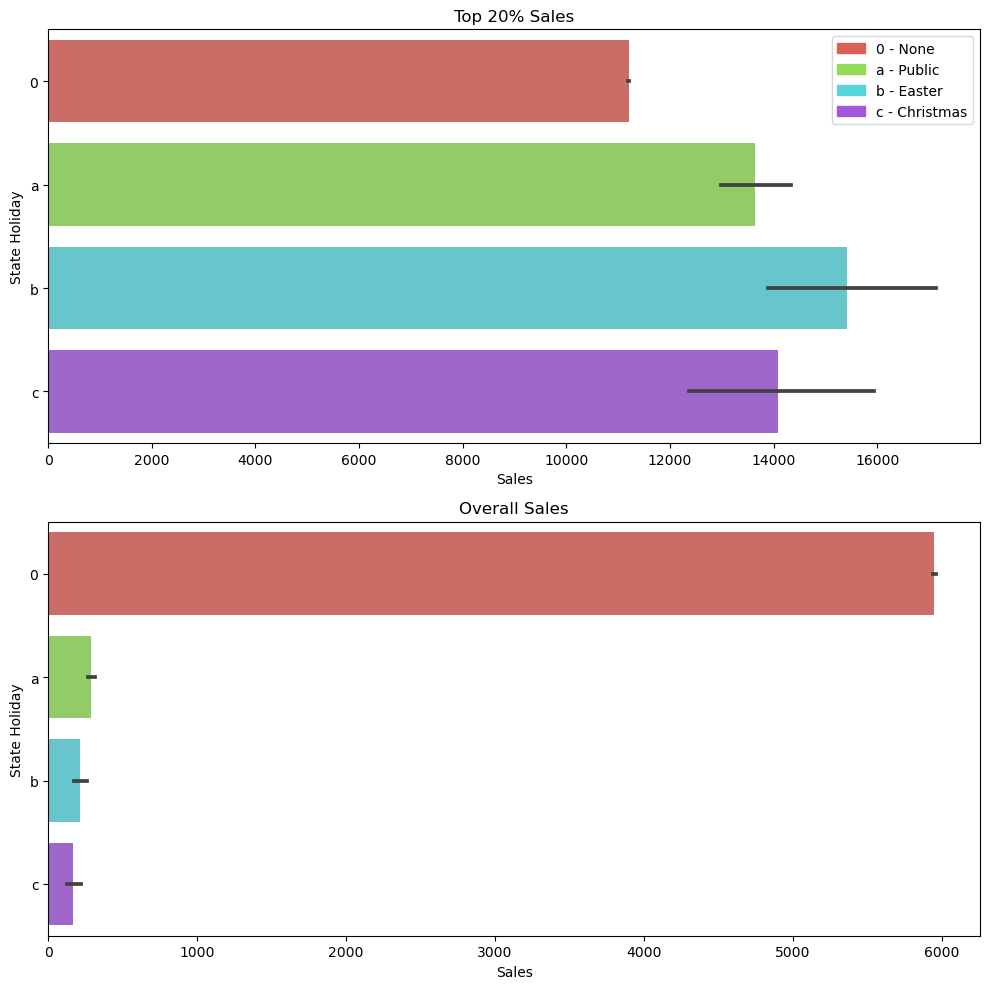

In [92]:
# Define a color palette with four distinct colors for the different types of state holidays
colors = sns.color_palette('hls', 4)

# Initialize a figure with a specified size to accommodate two vertically stacked subplots
plt.figure(figsize=(10, 10))

# First subplot: Displaying sales data for top 20% stores based on different state holidays
plt.subplot(2, 1, 1)
sns.barplot(data=top_20_clean, x='Sales', y='StateHoliday', palette=colors)
plt.xlabel('Sales')          
plt.ylabel('State Holiday')  
plt.title('Top 20% Sales')   

# Create a legend for the state holidays, explaining the respective color codes
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(['0 - None', 'a - Public', 'b - Easter', 'c - Christmas'])]
plt.legend(handles=legend_patches, loc='upper right')  # Display the legend in the upper right corner

# Second subplot: Displaying overall sales data based on different state holidays
plt.subplot(2, 1, 2)
sns.barplot(data=rossmann_clean, x='Sales', y='StateHoliday', palette=colors)
plt.xlabel('Sales')          
plt.ylabel('State Holiday')  
plt.title('Overall Sales')  

# Adjust the layout of the figure to prevent overlap and maintain neat presentation
plt.tight_layout()

* For the top 20% of sales, Easter holidays show the highest sales. However, for overall sales, the highest figures were observed during non-holiday periods.

### Competition Distance 

In [94]:
top_20_clean['CompetitionDistance'].describe().round(3)

count    203160.000
mean       5199.038
std        7805.721
min          20.000
25%         460.000
50%        1920.000
75%        6480.000
max       75860.000
Name: CompetitionDistance, dtype: float64

In [96]:
rossmann_clean['CompetitionDistance'].describe().round(3)

count    1014567.000
mean        5430.086
std         7715.324
min           20.000
25%          710.000
50%         2330.000
75%         6890.000
max        75860.000
Name: CompetitionDistance, dtype: float64

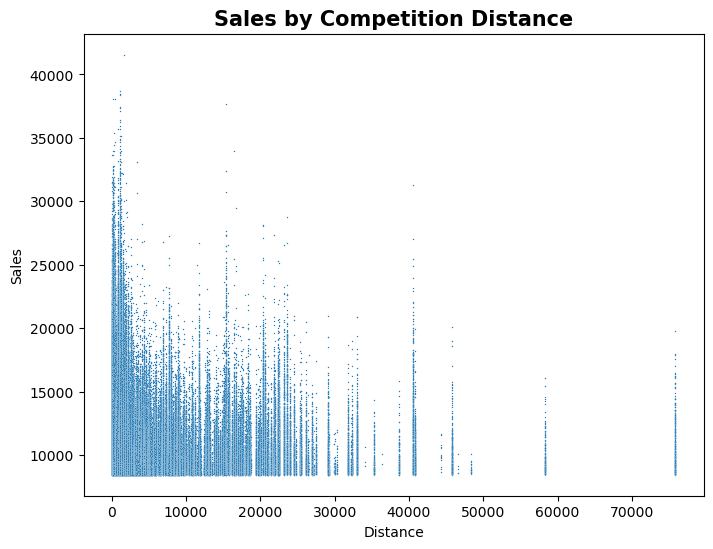

In [98]:
plt.figure(figsize=(8,6))

# Create a scatter plot to visualize the relationship between competition distance and sales
ax = sns.scatterplot(data=top_20_clean, x='CompetitionDistance', y='Sales', palette='hls',s=1)

# Set the labels and title for the plot
plt.xlabel('Distance')
plt.ylabel('Sales')
plt.title('Sales by Competition Distance', fontweight='bold', fontsize=15);

### To observe a clearer relationship, bin the distances.

In [100]:
top_20_dist = top_20_clean.copy()

# Define the bins for competition distances
bins = [0, 4000, 6000, top_20_clean['CompetitionDistance'].max()]

# Define the labels for each section
labels = ['Near', 'Moderate', 'Far']

# Categorising competition distances into 'Near', 'Moderate', and 'Far'.
top_20_dist['distance_category'] = pd.cut(top_20_clean['CompetitionDistance'], bins=bins, labels=labels)

In [101]:
rossmann_dist = rossmann_clean.copy()

# Define the bins for competition distances
bins = [0, 4000, 6000, rossmann_clean['CompetitionDistance'].max()]

# Define the labels for each section
labels = ['Near', 'Moderate', 'Far']

# Categorising competition distances into 'Near', 'Moderate', and 'Far'.
rossmann_dist['distance_category'] = pd.cut(rossmann_clean['CompetitionDistance'], bins=bins, labels=labels)

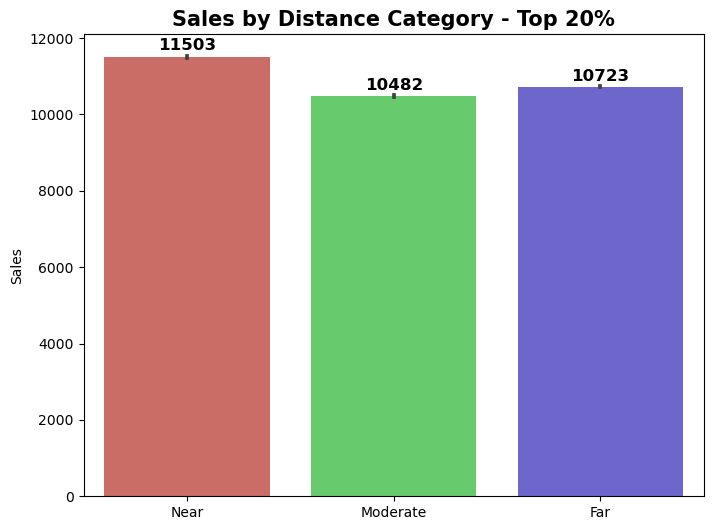

In [104]:
plt.figure(figsize=(8,6))

# Plotting a bar chart to show Sales by Distance Category
ax = sns.barplot(data=top_20_dist, x='distance_category', y='Sales', palette='hls')
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Sales by Distance Category - Top 20%', fontweight='bold', fontsize=15);

# Annotating each bar with its value
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom',weight='bold')

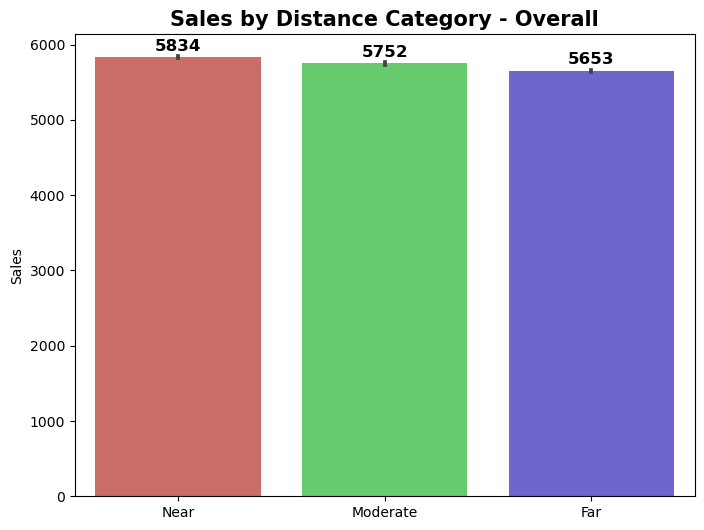

In [105]:
plt.figure(figsize=(8,6))

# Plotting a bar chart to show Sales by Distance Category
ax = sns.barplot(data=rossmann_dist, x='distance_category', y='Sales', palette='hls')
plt.xlabel('')
plt.ylabel('Sales')
plt.title('Sales by Distance Category - Overall', fontweight='bold', fontsize=15);

# Annotating each bar with its value
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height()*1.008, '%d' % int(p.get_height()), 
            fontsize=12, ha='center', va='bottom',weight='bold')

* For the top 20%, sales are highest when the distance is near and lowest for far distance. However, for overall sales, distance results in only minor variations in sales.

## Exploratory Data Analysis with Time

### Identifying the beginning and ending times of the dataframes.

In [108]:
beg_time_20 = top_20_clean.index.min()
end_time_20 = top_20_clean.index.max()

beg_time_overall = rossmann_clean.index.min()
end_time_overall = rossmann_clean.index.max()

print("Beginning time for Top 20% Sales:", beg_time_20)
print("Ending time for Top 20% Sales:", end_time_20)

print("\n")

print("Beginning time for Overall Sales:", beg_time_overall)
print("Ending time for Overall Sales:", end_time_overall)

Beginning time for Top 20% Sales: 2013-01-01 00:00:00
Ending time for Top 20% Sales: 2015-07-31 00:00:00


Beginning time for Overall Sales: 2013-01-01 00:00:00
Ending time for Overall Sales: 2015-07-31 00:00:00


### Yearly Sales and Customers

In [109]:
# Sort the top 20% dataframe by index
top_20_clean.sort_index(inplace=True)

# Compute the yearly average sales for the top 20% dataset
top_20_years = top_20_clean.resample("1Y").mean()

# Sort the overall dataframe by index
rossmann_clean.sort_index(inplace=True)

# Compute the yearly average sales for the overall dataset
rossmann_years = rossmann_clean.resample("1Y").mean()

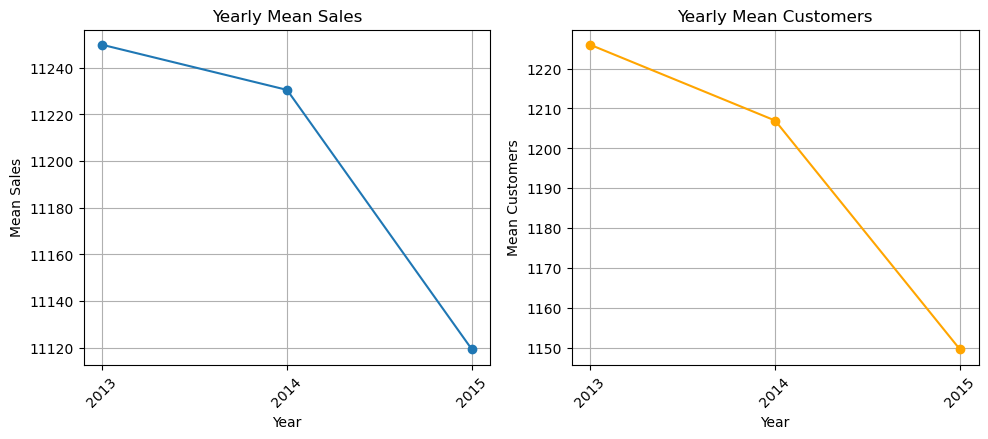

In [119]:
# Extract unique years from the data
years = [str(year) for year in top_20_years.index.year.unique()] 

plt.figure(figsize=(10, 8))

# Plot yearly mean sales for the top 20% dataset
plt.subplot(2,2,1)
plt.plot(top_20_years['Sales'], marker='o')
plt.title('Yearly Mean Sales')
plt.xlabel('Year')
plt.ylabel('Mean Sales')
plt.xticks(ticks=top_20_years.index, labels=years, rotation=45)
plt.grid()

# Plot yearly mean customers for the top 20% dataset
plt.subplot(2,2,2)
plt.plot(top_20_years['Customers'], marker='o', color='orange')
plt.title('Yearly Mean Customers')
plt.xlabel('Year')
plt.ylabel('Mean Customers')
plt.xticks(ticks=top_20_years.index, labels=years, rotation=45)
plt.grid()

plt.tight_layout()

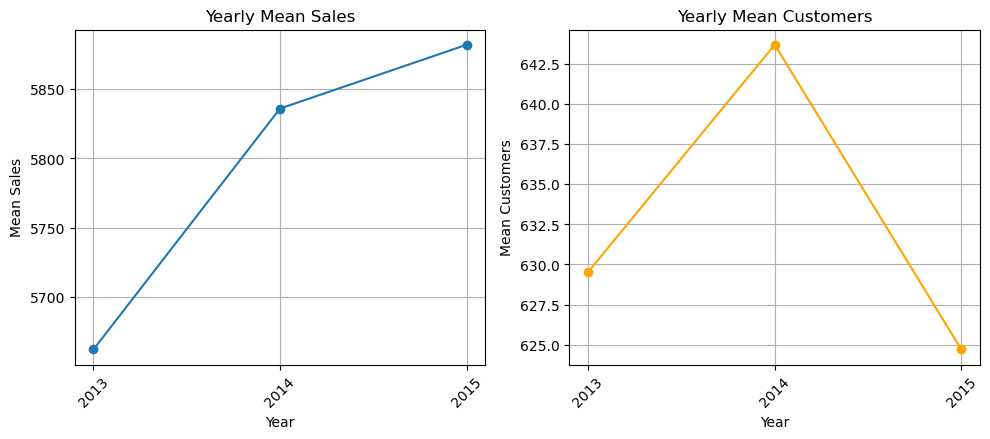

In [113]:
# Extract unique years from the dataset
years = [str(year) for year in rossmann_years.index.year.unique()]

plt.figure(figsize=(10, 8))

# Plot yearly mean sales for the entire dataset
plt.subplot(2,2,1)
plt.plot(rossmann_years['Sales'], marker='o')
plt.title('Yearly Mean Sales')
plt.xlabel('Year')
plt.ylabel('Mean Sales')
plt.xticks(ticks=rossmann_years.index, labels=years, rotation=45)
plt.grid()

# Plot yearly mean customers for the entire dataset
plt.subplot(2,2,2)
plt.plot(rossmann_years['Customers'], marker='o', color='orange')
plt.title('Yearly Mean Customers')
plt.xlabel('Year')
plt.ylabel('Mean Customers')
plt.xticks(ticks=rossmann_years.index, labels=years, rotation=45)
plt.grid()

plt.tight_layout()

* The sales of the top 20% have decreased over the years, with a notable drop in 2015. On the other hand, overall sales have been growing.

### Quarterly Sales and Customers

In [112]:
# Sort the top 20% dataframe by index
top_20_clean.sort_index(inplace=True)

# Compute the quarterly average sales for the top 20%
top_20_quarters = top_20_clean.resample("Q").mean()

# Sort the overall dataframe by index
rossmann_clean.sort_index(inplace=True)

# Compute the quarterly average sales for the overall dataset
rossmann_quarters = rossmann_clean.resample("Q").mean()

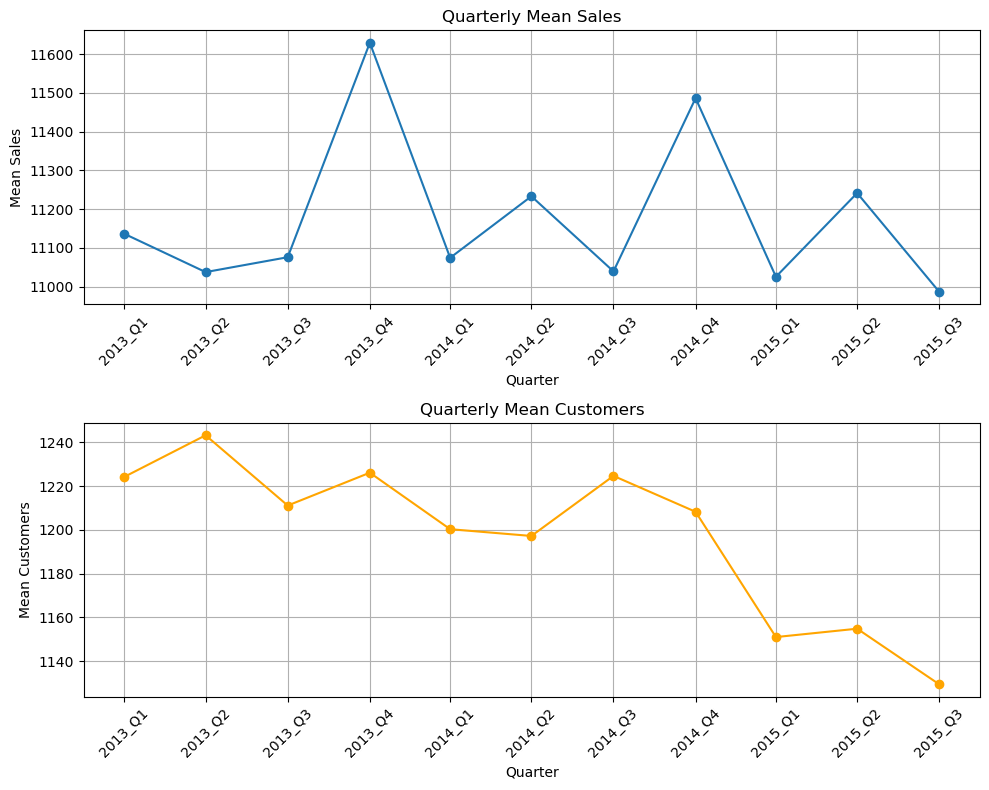

In [115]:
# Generate quarter labels for the x-axis
quarter_labels = [f"{date.year}_Q{((date.month - 1) // 3) + 1}" for date in top_20_quarters.index]

plt.figure(figsize=(10, 8))

# Plot quarterly mean sales for the top 20% dataset
plt.subplot(2,1,1)
plt.plot(top_20_quarters['Sales'], marker='o')
plt.title('Quarterly Mean Sales')
plt.xlabel('Quarter')
plt.ylabel('Mean Sales')
plt.xticks(ticks=top_20_quarters.index, labels=quarter_labels, rotation=45)
plt.grid()

# Plot quarterly mean customers for the top 20% dataset
plt.subplot(2,1,2)
plt.plot(top_20_quarters['Customers'], marker='o', color='orange')
plt.title('Quarterly Mean Customers')
plt.xlabel('Quarter')
plt.ylabel('Mean Customers')
plt.xticks(ticks=top_20_quarters.index, labels=quarter_labels, rotation=45)
plt.grid()

plt.tight_layout()

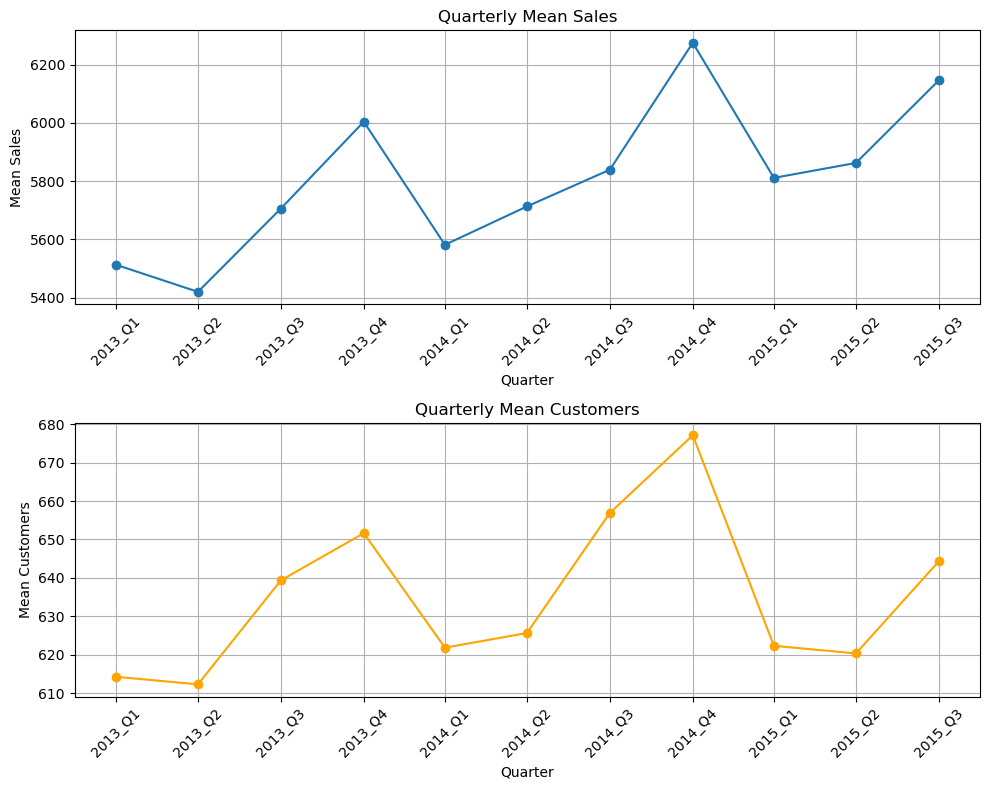

In [120]:
# Generate quarter labels for the x-axis based on rossmann_quarters data
quarter_labels = [f"{date.year}_Q{((date.month - 1) // 3) + 1}" for date in rossmann_quarters.index]

plt.figure(figsize=(10, 8))

# Plot quarterly mean sales for the entire dataset
plt.subplot(2,1,1)
plt.plot(rossmann_quarters['Sales'], marker='o')
plt.title('Quarterly Mean Sales')
plt.xlabel('Quarter')
plt.ylabel('Mean Sales')
plt.xticks(ticks=rossmann_quarters.index, labels=quarter_labels, rotation=45)
plt.grid()

# Plot quarterly mean customers for the entire dataset
plt.subplot(2,1,2)
plt.plot(rossmann_quarters['Customers'], marker='o', color='orange')
plt.title('Quarterly Mean Customers')
plt.xlabel('Quarter')
plt.ylabel('Mean Customers')
plt.xticks(ticks=rossmann_quarters.index, labels=quarter_labels, rotation=45)
plt.grid()

plt.tight_layout()

* For both the top 20% and overall sales, the 4th quarter recorded the highest figures. Notably, while the top 20% sales show a consistent decline, the overall sales exhibit a steady increase.


* The significant drop in 2015 for Top 20% sales can be attributed to the fact that the mean sales for 2015 doesn't include Q4. Considering the trends, Q4 could have boosted the mean sales.

### Monthly Sales and Customers

In [116]:
# Sort the top 20% dataframe by index
top_20_clean.sort_index(inplace=True)

# Compute the monthly average sales for the top 20% dataset
top_20_months = top_20_clean.resample("1M").mean()

# Sort the overall dataframe by index
rossmann_clean.sort_index(inplace=True)

# Compute the monthly average sales for the overall dataset
rossmann_months = rossmann_clean.resample("1M").mean()

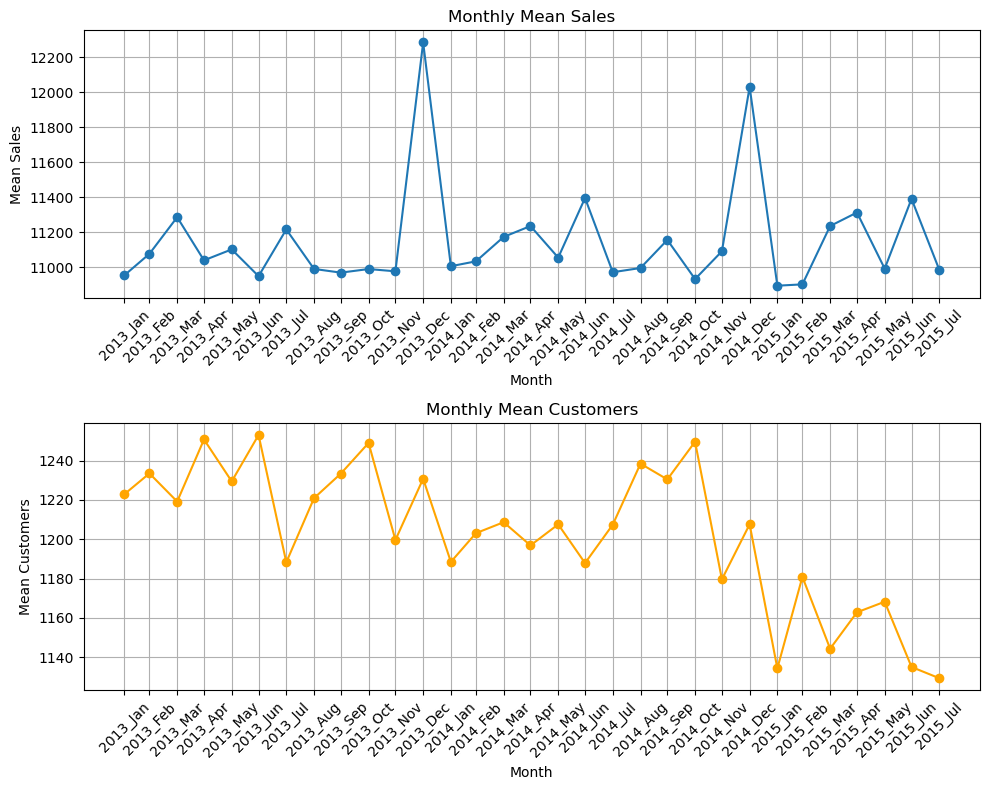

In [117]:
# Generate month labels for the x-axis based on top_20_months data
month_labels = [f"{date.year}_{date.strftime('%b')}" for date in top_20_months.index]

plt.figure(figsize=(10, 8))

# Plot monthly mean sales for the top 20% dataset
plt.subplot(2,1,1)
plt.plot(top_20_months['Sales'], marker='o')
plt.title('Monthly Mean Sales')
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.xticks(ticks=top_20_months.index, labels=month_labels, rotation=45)
plt.grid()

# Plot monthly mean customers for the top 20% dataset
plt.subplot(2,1,2)
plt.plot(top_20_months['Customers'], marker='o', color='orange')
plt.title('Monthly Mean Customers')
plt.xlabel('Month')
plt.ylabel('Mean Customers')
plt.xticks(ticks=top_20_months.index, labels=month_labels, rotation=45)
plt.grid()

plt.tight_layout()

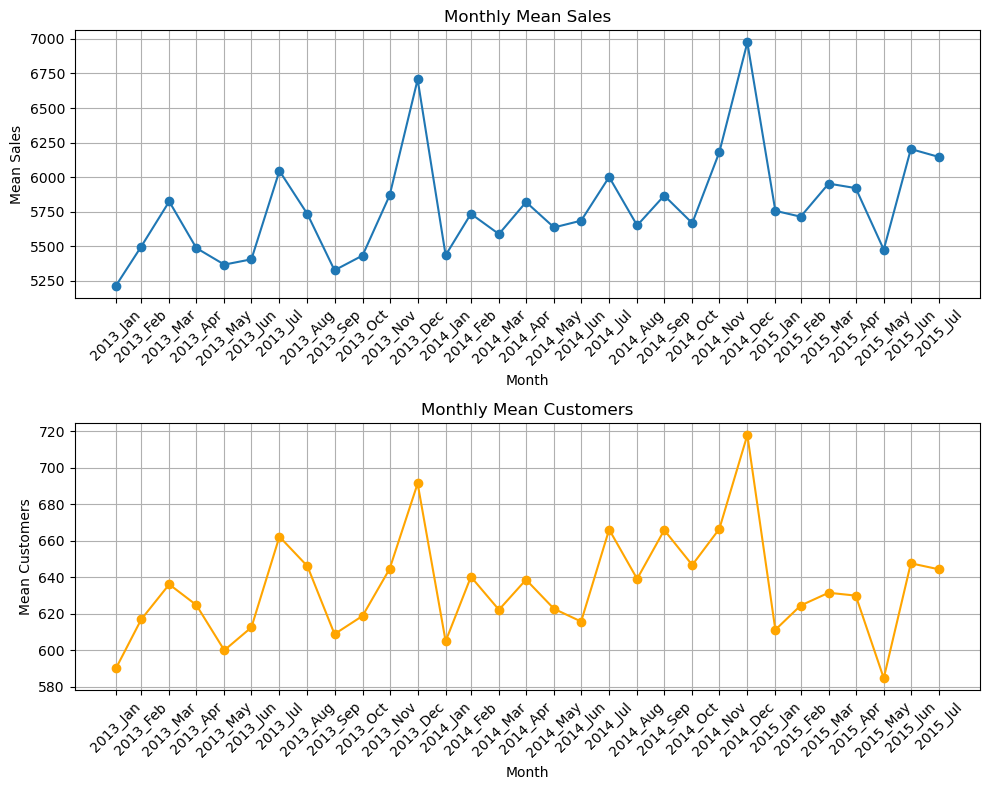

In [118]:
# Generate month labels for the x-axis based on rossmann_months data
month_labels = [f"{date.year}_{date.strftime('%b')}" for date in rossmann_months.index]

plt.figure(figsize=(10, 8))

# Plot monthly mean sales for the rossmann dataset
plt.subplot(2,1,1)
plt.plot(rossmann_months['Sales'], marker='o')
plt.title('Monthly Mean Sales')
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.xticks(ticks=rossmann_months.index, labels=month_labels, rotation=45)
plt.grid()

# Plot monthly mean customers for the rossmann dataset
plt.subplot(2,1,2)
plt.plot(rossmann_months['Customers'], marker='o', color='orange')
plt.title('Monthly Mean Customers')
plt.xlabel('Month')
plt.ylabel('Mean Customers')
plt.xticks(ticks=rossmann_months.index, labels=month_labels, rotation=45)
plt.grid()

plt.tight_layout()

* In Q4, sales, especially in December, elevated the average sales for the quarter.

### Weekly Sales and Customers

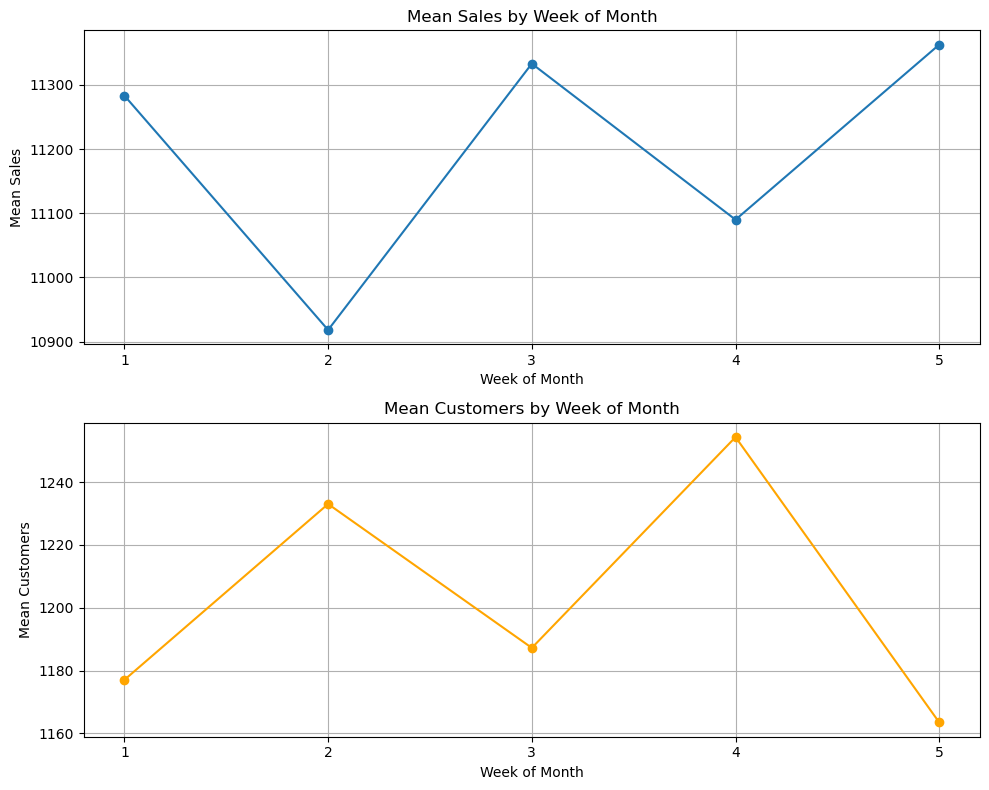

In [123]:
# Assign week numbers for each day of the month for both dataframes
top_20_clean['week_of_month'] = top_20_clean.index.day // 7 + 1
rossmann_clean['week_of_month'] = rossmann_clean.index.day // 7 + 1 

# Compute the mean values for each week of the month
top_20_weekly = top_20_clean.groupby('week_of_month').mean()
rossmann_weekly = rossmann_clean.groupby('week_of_month').mean()

# Set up the plot space
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot weekly mean sales for the top_20 dataset
ax[0].plot(top_20_weekly['Sales'], marker='o')
ax[0].set_title('Mean Sales by Week of Month')
ax[0].set_xlabel('Week of Month')
ax[0].set_ylabel('Mean Sales')
ax[0].set_xticks([1, 2, 3, 4, 5])  
ax[0].grid(True)

# Plot weekly mean customers for the top_20 dataset
ax[1].plot(top_20_weekly['Customers'], marker='o', color='orange')
ax[1].set_title('Mean Customers by Week of Month')
ax[1].set_xlabel('Week of Month')
ax[1].set_ylabel('Mean Customers')
ax[1].set_xticks([1, 2, 3, 4, 5]) 
ax[1].grid(True)

# Adjust plot layout and display the plot
plt.tight_layout()

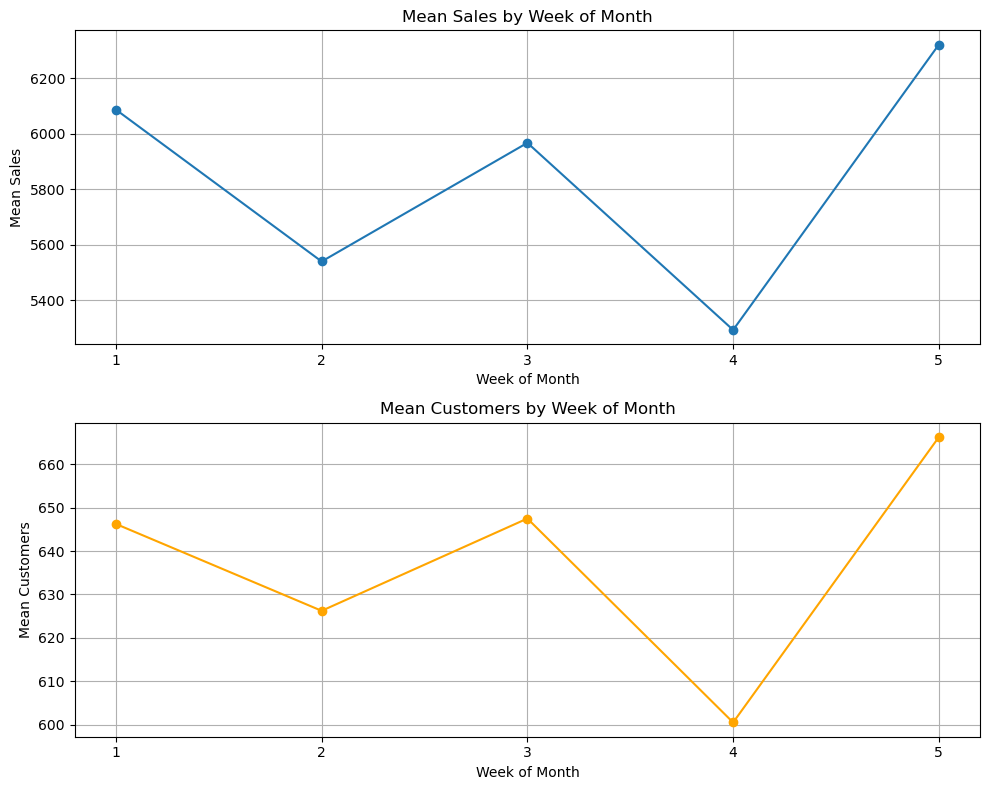

In [122]:
# Set up the plot space for weekly mean values from the rossmann dataset
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot weekly mean sales for the rossmann dataset
ax[0].plot(rossmann_weekly['Sales'], marker='o')
ax[0].set_title('Mean Sales by Week of Month')
ax[0].set_xlabel('Week of Month')
ax[0].set_ylabel('Mean Sales')
ax[0].set_xticks([1, 2, 3, 4, 5])  
ax[0].grid(True)

# Plot weekly mean customers for the rossmann dataset
ax[1].plot(rossmann_weekly['Customers'], marker='o', color='orange')
ax[1].set_title('Mean Customers by Week of Month')
ax[1].set_xlabel('Week of Month')
ax[1].set_ylabel('Mean Customers')
ax[1].set_xticks([1, 2, 3, 4, 5]) 
ax[1].grid(True)

# Adjust plot layout and display the plot
plt.tight_layout()
plt.show()

### Daily Sales and Customers

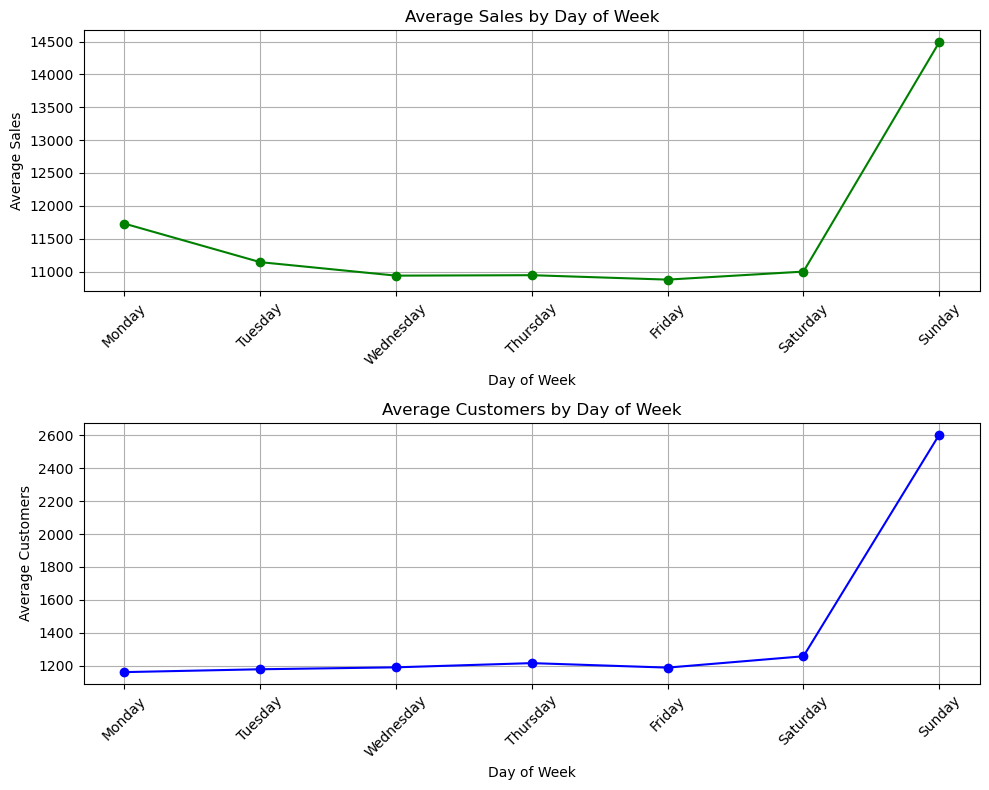

In [80]:
# Calculate mean values for Sales and Customers by day of the week for the top_20% dataset
top_20_daily = top_20_clean.groupby('DayOfWeekName')[['Sales', 'Customers']].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Set up the plot space
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot average sales for each day of the week for the top_20% dataset
ax[0].plot(top_20_daily['Sales'], marker='o', color='g')
ax[0].set_title('Average Sales by Day of Week')
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Average Sales')
ax[0].grid(True)
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

# Plot average customers for each day of the week for the top_20% dataset
ax[1].plot(top_20_daily['Customers'], marker='o', color='b')
ax[1].set_title('Average Customers by Day of Week')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Average Customers')
ax[1].grid(True)
ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

# Adjust plot layout and display the plot
plt.tight_layout()

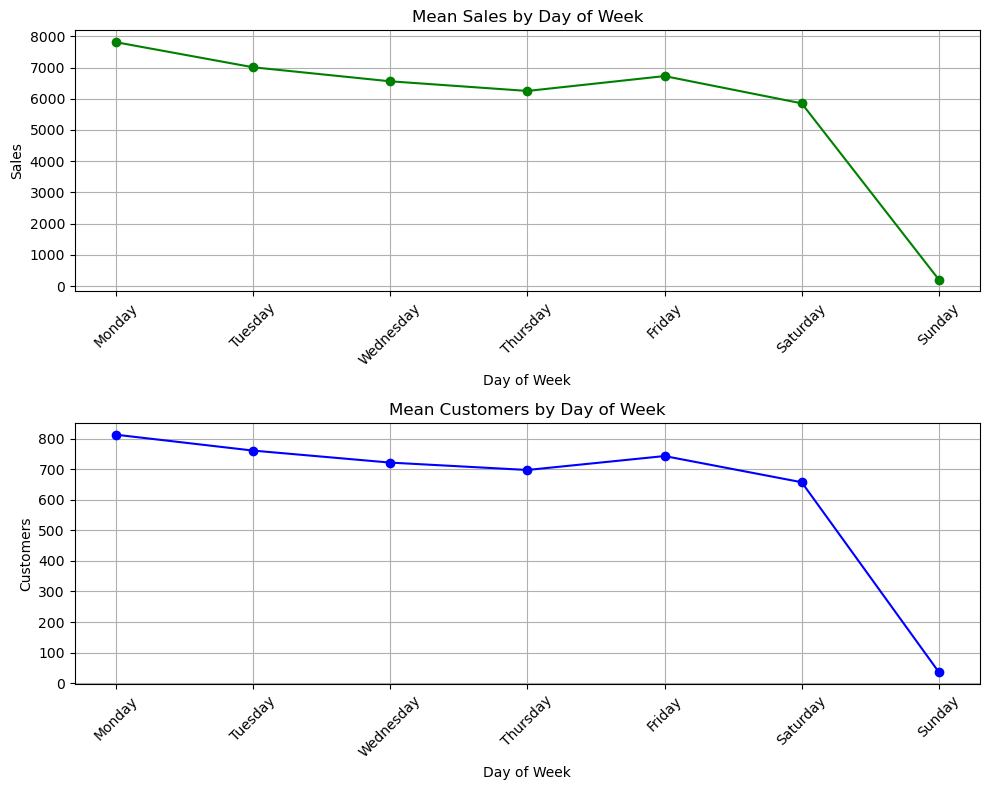

In [124]:
# Calculate the mean values for Sales and Customers for each day of the week for the Rossman dataset
rossmann_daily = rossmann_clean.groupby('DayOfWeekName')[['Sales', 'Customers']].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Initialize the plot space
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the average sales values for each day of the week
ax[0].plot(rossmann_daily['Sales'], marker='o', color='g', label='Total')
ax[0].set_title('Mean Sales by Day of Week')
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Sales')
ax[0].grid(True)
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

# Plot the average customer counts for each day of the week
ax[1].plot(rossmann_daily['Customers'], marker='o', color='b', label='Total')
ax[1].set_title('Mean Customers by Day of Week')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Customers')
ax[1].grid(True)
ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

# Adjust plot layout and display
plt.tight_layout()

In [125]:
rossmann_daily[rossmann_daily.index=='Sunday']

,Sales,Customers
DayOfWeekName,,
Sunday,204.715027,35.880031


In [83]:
top_20_clean[top_20_clean['DayOfWeekName']=='Sunday']['Open'].value_counts()

1    1357
Name: Open, dtype: int64

In [84]:
rossmann_clean[rossmann_clean['DayOfWeekName']=='Sunday']['Open'].value_counts()

0    140761
1      3593
Name: Open, dtype: int64

* A key difference in sales between the top 20% of stores and the overall stores lies in their operation on Sundays. Every store in the top 20% is open, but across all stores, only a mere 2% open their doors on Sundays. If we exclude the top 20% from this figure, even fewer stores are open on this day.


* For the top 20% of stores, sales peak on Mondays and gradually decrease until Saturday, then surge again on Sunday. In contrast, for all stores, sales are highest on Mondays, decrease gradually throughout the week, and hit the lowest point on Sundays.

### competition open since 

In [164]:
# Filtering records from the top_20_clean dataset where the competition opened in the year 2013
cosy_2013 = top_20_clean[top_20_clean['CompetitionOpenSinceYear']==2013]

# Filtering records from the top_20_clean dataset where the competition opened in the year 2014
cosy_2014 = top_20_clean[top_20_clean['CompetitionOpenSinceYear']==2014]

# Filtering records from the top_20_clean dataset where the competition opened in the year 2015
cosy_2015 = top_20_clean[top_20_clean['CompetitionOpenSinceYear']==2015]

In [165]:
# Sorting the 2013 dataset by index and then resampling to calculate the monthly mean
cosy_2013.sort_index(inplace=True)
cosy_2013_months = cosy_2013.resample("1M").mean()

# Sorting the 2014 dataset by index and then resampling to calculate the monthly mean
cosy_2014.sort_index(inplace=True)
cosy_2014_months = cosy_2014.resample("1M").mean()

# Sorting the 2015 dataset by index and then resampling to calculate the monthly mean
cosy_2015.sort_index(inplace=True)
cosy_2015_months = cosy_2015.resample("1M").mean()

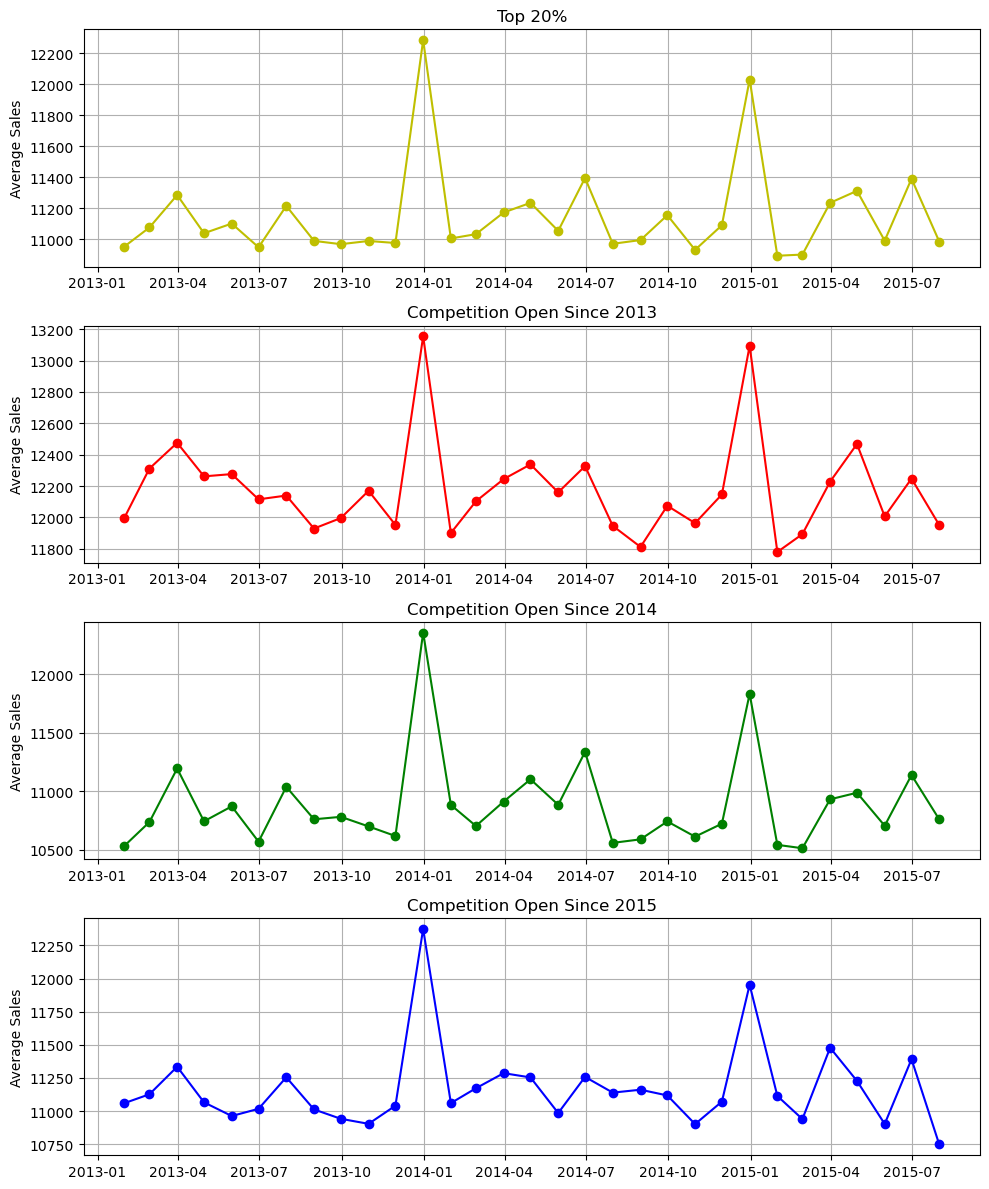

In [168]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12))

# Plotting average sales for Top 20%
ax[0].plot(top_20_months['Sales'], marker='o', color='y')
ax[0].set_title('Top 20%')
ax[0].set_ylabel('Average Sales')
ax[0].grid(True)

# Plotting average sales for competition open since 2013
ax[1].plot(cosy_2013_months['Sales'], marker='o', color='r')
ax[1].set_title('Competition Open Since 2013')
ax[1].set_ylabel('Average Sales')
ax[1].grid(True)

# Plotting average sales for competition open since 2014
ax[2].plot(cosy_2014_months['Sales'], marker='o', color='g')
ax[2].set_title('Competition Open Since 2014')
ax[2].set_ylabel('Average Sales')
ax[2].grid(True)

# Plotting average sales for competition open since 2015
ax[3].plot(cosy_2015_months['Sales'], marker='o', color='b')
ax[3].set_title('Competition Open Since 2015')
ax[3].set_ylabel('Average Sales') 
ax[3].grid(True)

# Adjusting the layout to prevent overlaps and displaying the plot
plt.tight_layout()

In [169]:
# Filtering the top 20 stores based on the month the competition opened
cosm_01 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==1]
cosm_02 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==2]
cosm_03 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==3]
cosm_04 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==4]
cosm_05 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==5]
cosm_06 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==6]
cosm_07 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==7]
cosm_08 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==8]
cosm_09 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==9]
cosm_10 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==10]
cosm_11 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==11]
cosm_12 = top_20_clean[top_20_clean['CompetitionOpenSinceMonth']==12]

In [170]:
# Resampling the filtered datasets by month and calculating the mean for each month
cosm_01.sort_index(inplace=True)
cosm_01_months = cosm_01.resample("1M").mean()

cosm_02.sort_index(inplace=True)
cosm_02_months = cosm_02.resample("1M").mean()

cosm_03.sort_index(inplace=True)
cosm_03_months = cosm_03.resample("1M").mean()

cosm_04.sort_index(inplace=True)
cosm_04_months = cosm_04.resample("1M").mean()

cosm_05.sort_index(inplace=True)
cosm_05_months = cosm_05.resample("1M").mean()

cosm_06.sort_index(inplace=True)
cosm_06_months = cosm_06.resample("1M").mean()

cosm_07.sort_index(inplace=True)
cosm_07_months = cosm_07.resample("1M").mean()

cosm_08.sort_index(inplace=True)
cosm_08_months = cosm_08.resample("1M").mean()

cosm_09.sort_index(inplace=True)
cosm_09_months = cosm_09.resample("1M").mean()

cosm_10.sort_index(inplace=True)
cosm_10_months = cosm_10.resample("1M").mean()

cosm_11.sort_index(inplace=True)
cosm_11_months = cosm_11.resample("1M").mean()

cosm_12.sort_index(inplace=True)
cosm_12_months = cosm_12.resample("1M").mean()

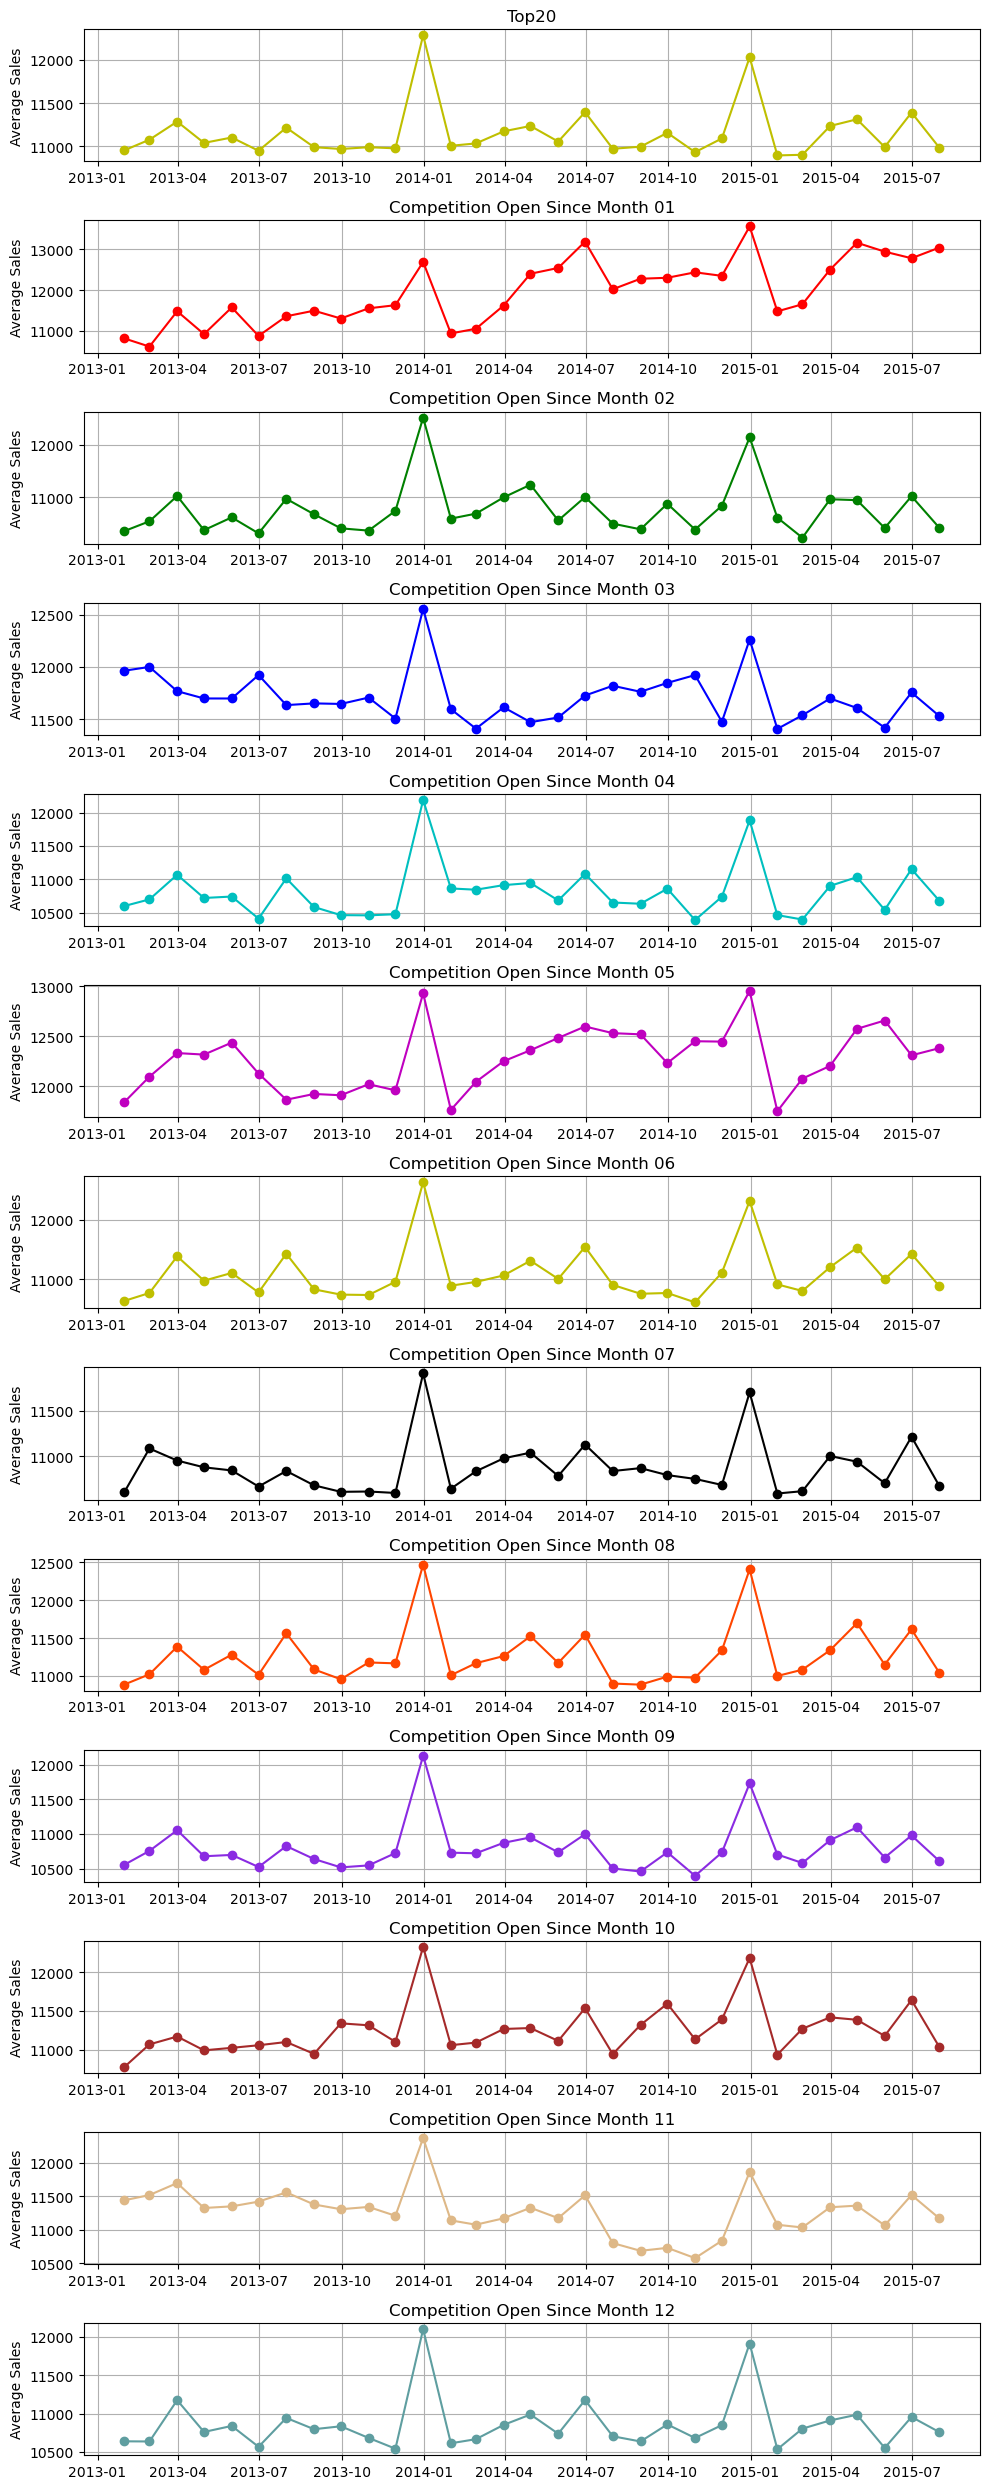

In [171]:
fig, ax = plt.subplots(13, 1, figsize=(10, 25))

# List of monthly dataframes
cosm_dfs = [cosm_01_months, cosm_02_months, cosm_03_months, cosm_04_months, cosm_05_months, 
            cosm_06_months, cosm_07_months, cosm_08_months, cosm_09_months, cosm_10_months, 
            cosm_11_months, cosm_12_months]

# Defining colors for each month's plot
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '#FF4500', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0']

# Plotting the top 20 average sales
ax[0].plot(top_20_months['Sales'], marker='o', color='y')
ax[0].set_title('Top20')
ax[0].set_ylabel('Average Sales')
ax[0].grid(True)

# Looping through each month's dataframe to plot the average sales
for i, (df, color) in enumerate(zip(cosm_dfs, colors)):
    ax[i+1].plot(df['Sales'], marker='o', color=color)
    ax[i+1].set_title(f'Competition Open Since Month {str(i+1).zfill(2)}')
    ax[i+1].set_ylabel('Average Sales')
    ax[i+1].grid(True)

# Adjusting the layout for readability and displaying the plot
plt.tight_layout()  

### Initially, we assumed that sales would decrease after a competition opened. However, regardless of "CompetitionOpenSinceYear," all the graphs depict a nearly similar trend. Hence, we can conclude that the opening of a competition does not impact sales in general. Same applies for 'CompetitionOpenSinceMonth'.

 # Prediction Model

In [210]:
df_model = top_20_clean.copy()

In [211]:
df_model.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeekName                 object
source                        object
week_of_month                  int64
dtype: object

* We exclude 'DayOfWeekName' column because this variable is redundant due to the existence of 'DayOfWeek', and was created for better interpretation.


* Throughout the EDA we have verified that 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' do not affect the sales. So, we drop them as well.


* 'Store' variable is just a unique ID for each store and ofcourse it does not affect sales, if it does it's just a coincidence.

In [212]:
df_model = df_model.drop(['Store','DayOfWeekName','Open','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','source','week_of_month'],axis=1)

In [213]:
df_model.dtypes

DayOfWeek                int64
Sales                    int64
Customers                int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                   int64
dtype: object

* The columns 'DayOfWeek', 'StateHoliday', 'StoreType', and 'Assortment' are representing categorical data. We will apply one-hot encoding (using dummy variables) to make them suitable for regression modeling.

In [214]:
# one-hot encoding

dayofweek_dummy = pd.get_dummies(df_model.DayOfWeek, prefix='Dayofweek')
df_model = pd.concat([df_model, dayofweek_dummy], axis = 1)
df_model = df_model.drop(['DayOfWeek'],axis=1)

stateholiday_dummy = pd.get_dummies(df_model.StateHoliday, prefix='Stateholiday')
df_model = pd.concat([df_model, stateholiday_dummy], axis = 1)
df_model = df_model.drop(['StateHoliday'],axis=1)

assortment_dummy = pd.get_dummies(df_model.Assortment, prefix='Assortment')
df_model = pd.concat([df_model, assortment_dummy], axis = 1)
df_model = df_model.drop(['Assortment'],axis=1)

storetype_dummy = pd.get_dummies(df_model.StoreType, prefix='Storetype')
df_model = pd.concat([df_model, storetype_dummy], axis = 1)
df_model = df_model.drop(['StoreType'],axis=1)

In [261]:
# Months
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Initialize dummy columns for each month with 0
for Month in Months:
    df_model[Month] = 0

# Set appropriate month columns to 1
for i, Month in enumerate(Months, start=1):
    df_model.loc[df_model.index.month == i, Month] = 1

### Heatmap

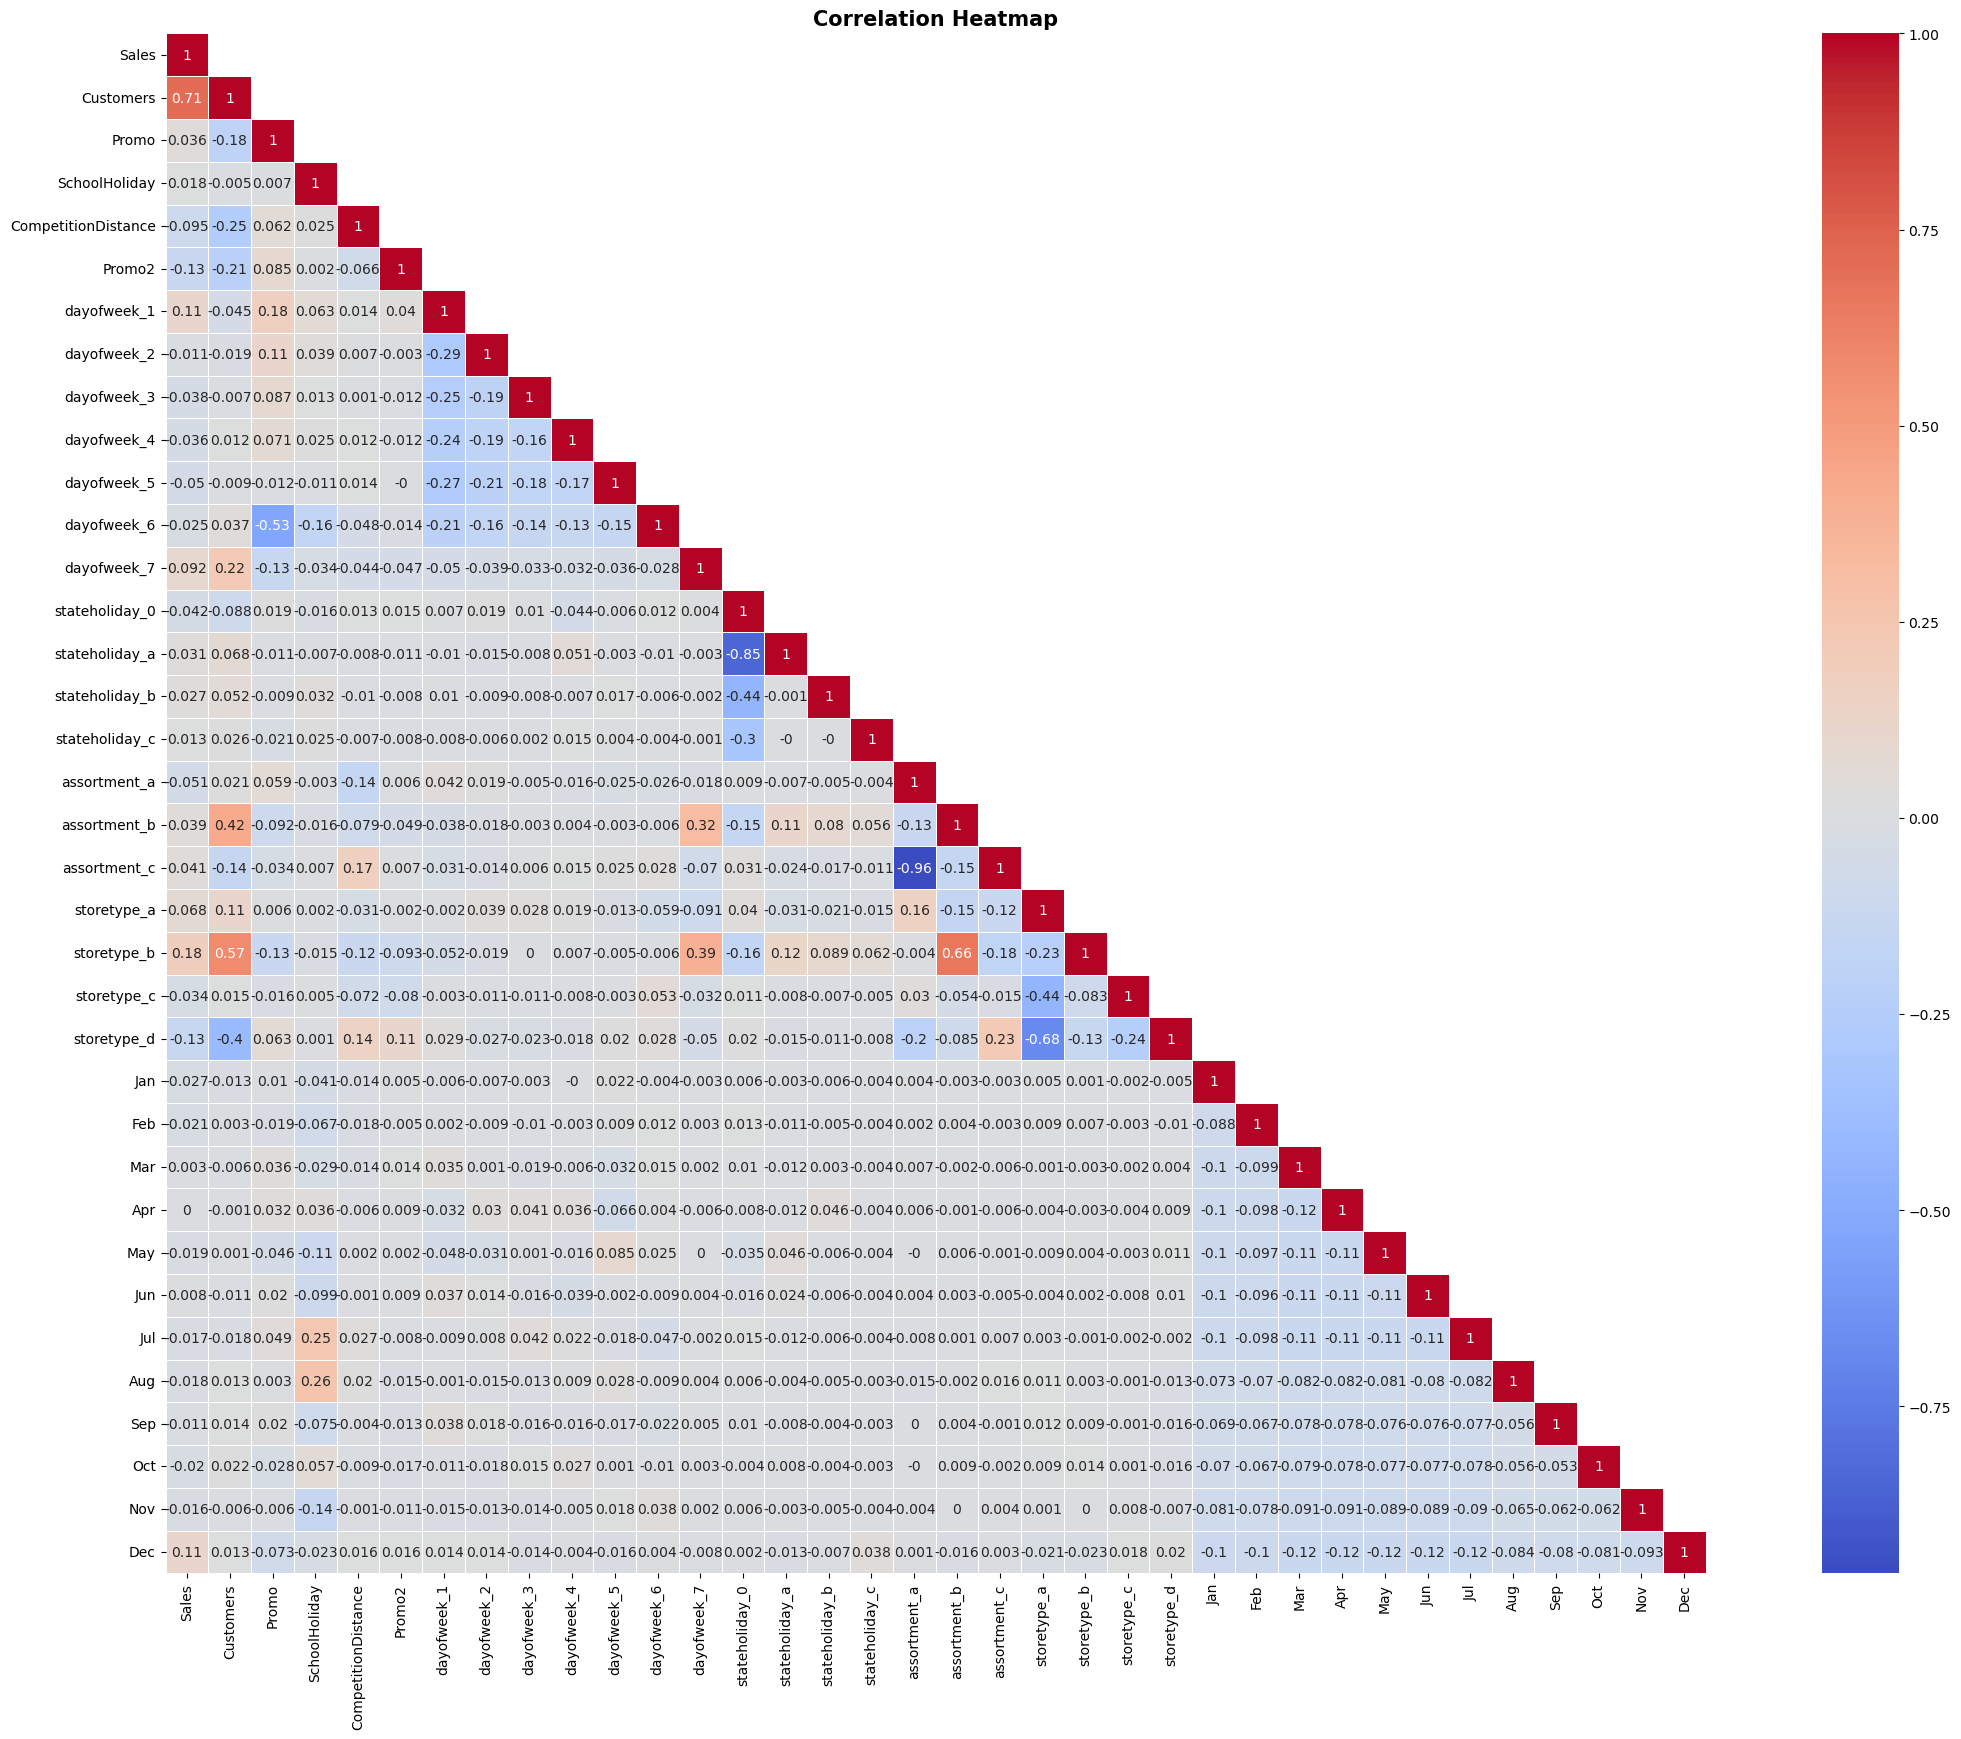

In [265]:
# Calculate the correlation table
corr = df_model.corr().round(3) 
# Create a mask to exclude the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1) 
plt.figure(figsize=(30,20))
sns.heatmap(data=corr, annot=True, mask=mask, linewidths=0.5, square=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontweight='bold', fontsize=15)

plt.show()

In [ ]:
X = df_model.drop(['Sales'],axis=1) 
X_wo_cust = df_model.drop(['Sales','Customers'],axis=1) 
Y = df_model['Sales']

In [296]:
X.dtypes

Customers                int64
Promo                    int64
SchoolHoliday            int64
CompetitionDistance    float64
Promo2                   int64
dayofweek_1              uint8
dayofweek_2              uint8
dayofweek_3              uint8
dayofweek_4              uint8
dayofweek_5              uint8
dayofweek_6              uint8
dayofweek_7              uint8
stateholiday_0           uint8
stateholiday_a           uint8
stateholiday_b           uint8
stateholiday_c           uint8
assortment_a             uint8
assortment_b             uint8
assortment_c             uint8
storetype_a              uint8
storetype_b              uint8
storetype_c              uint8
storetype_d              uint8
Jan                      int64
Feb                      int64
Mar                      int64
Apr                      int64
May                      int64
Jun                      int64
Jul                      int64
Aug                      int64
Sep                      int64
Oct     

In [297]:
X_wo_cust.dtypes

Promo                    int64
SchoolHoliday            int64
CompetitionDistance    float64
Promo2                   int64
dayofweek_1              uint8
dayofweek_2              uint8
dayofweek_3              uint8
dayofweek_4              uint8
dayofweek_5              uint8
dayofweek_6              uint8
dayofweek_7              uint8
stateholiday_0           uint8
stateholiday_a           uint8
stateholiday_b           uint8
stateholiday_c           uint8
assortment_a             uint8
assortment_b             uint8
assortment_c             uint8
storetype_a              uint8
storetype_b              uint8
storetype_c              uint8
storetype_d              uint8
Jan                      int64
Feb                      int64
Mar                      int64
Apr                      int64
May                      int64
Jun                      int64
Jul                      int64
Aug                      int64
Sep                      int64
Oct                      int64
Nov     

In [347]:
X_train, X_test, Y_train, Y_test  = train_test_split(
    X, Y, test_size=0.25,random_state=42)

In [331]:
X_train_wo_cust, X_test_wo_cust, Y_train_wo_cust, Y_test_wo_cust = train_test_split(
    X_wo_cust, Y, test_size=0.25,random_state=42)

In [336]:
# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train);  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions = linear.predict(X_train)  # Get model predictions for both.
testing_predictions = linear.predict(X_test)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.714025,1558.786612,1139.571701
test,0.710542,1556.522322,1140.147366


In [337]:
# Construct and fit the model
linear_wo_cust = LinearRegression()  # Instantatiate the linear regression model
linear_wo_cust.fit(X_train_wo_cust,Y_train_wo_cust);  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions_wo_cust = linear_wo_cust.predict(X_train_wo_cust)  # Get model predictions for both.
testing_predictions_wo_cust = linear_wo_cust.predict(X_test_wo_cust)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train_wo_cust, training_predictions_wo_cust),
        "test": r2_score(Y_test_wo_cust, testing_predictions_wo_cust)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train_wo_cust, training_predictions_wo_cust, squared=False),
        "test": mean_squared_error(Y_test_wo_cust, testing_predictions_wo_cust, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train_wo_cust, training_predictions_wo_cust),
        "test": mean_absolute_error(Y_test_wo_cust, testing_predictions_wo_cust),
    },
})

,R^2,RMSE,MAE
train,0.130092,2718.690049,1937.284287
test,0.125807,2704.994843,1931.077396


In [338]:
nX=MaxAbsScaler().fit_transform(X)

# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2, 2, num=21) 

X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y,
    test_size=0.25,
    random_state=1235
) 

ridgecv = RidgeCV(alfas)

# Fit the Ridge regression model with cross-validation to the training data
ridgecv.fit(X_train,Y_train)


training_predictions = ridgecv.predict(X_train)
testing_predictions = ridgecv.predict(X_test) 

# Retrieve the optimal regularization parameter (alpha) for Ridge regression
ridge_opt_alpha = ridgecv.alpha_

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train,training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.713304,1557.290054,1138.845178
test,0.712711,1561.110264,1141.407952


In [339]:
nX_wo_cust = MaxAbsScaler().fit_transform(X_wo_cust)

# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2, 2, num=21) 


ridgecv_wo_cust = RidgeCV(alfas)

# Fit the Ridge regression model with cross-validation to the training data
ridgecv_wo_cust.fit(X_train_wo_cust,Y_train_wo_cust)


training_predictions_wo_cust = ridgecv_wo_cust.predict(X_train_wo_cust)
testing_predictions_wo_cust = ridgecv_wo_cust.predict(X_test_wo_cust) 

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train_wo_cust,training_predictions_wo_cust),
        "test": r2_score(Y_test_wo_cust, testing_predictions_wo_cust)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train_wo_cust, training_predictions_wo_cust, squared=False),
        "test": mean_squared_error(Y_test_wo_cust, testing_predictions_wo_cust, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train_wo_cust, training_predictions_wo_cust),
        "test": mean_absolute_error(Y_test_wo_cust, testing_predictions_wo_cust),
    },
})

,R^2,RMSE,MAE
train,0.130074,2718.717016,1937.334530
test,0.125905,2704.843174,1931.086122


In [340]:
DTR = DecisionTreeRegressor(random_state=42)
DTR.fit(X_train, Y_train)
Y_pred_DTR = DTR.predict(X_test)

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, DTR.predict(X_train)),
        "test": r2_score(Y_test, Y_pred_DTR)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, DTR.predict(X_train), squared=False),
        "test": mean_squared_error(Y_test, Y_pred_DTR, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, DTR.predict(X_train)),
        "test": mean_absolute_error(Y_test, Y_pred_DTR),
    },
})

,R^2,RMSE,MAE
train,0.999823,38.714940,2.865120
test,0.846614,1140.686831,754.918544


In [341]:
DTR_wo_cust = DecisionTreeRegressor(random_state=42)
DTR_wo_cust.fit(X_train_wo_cust, Y_train_wo_cust)
Y_pred_DTR_wo_cust = DTR_wo_cust.predict(X_test_wo_cust)

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train_wo_cust, DTR_wo_cust.predict(X_train_wo_cust)),
        "test": r2_score(Y_test_wo_cust, Y_pred_DTR_wo_cust)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train_wo_cust, DTR_wo_cust.predict(X_train_wo_cust), squared=False),
        "test": mean_squared_error(Y_test_wo_cust, Y_pred_DTR_wo_cust, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train_wo_cust, DTR_wo_cust.predict(X_train_wo_cust)),
        "test": mean_absolute_error(Y_test_wo_cust, Y_pred_DTR_wo_cust),
    },
})

,R^2,RMSE,MAE
train,0.820086,1236.388104,742.410553
test,0.605275,1817.649669,1217.776426


In [389]:
RFR = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model to the training data
RFR.fit(X_train, Y_train)  

# Make predictions using the Random Forest model
Y_pred_RFR = RFR.predict(X_test)

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, RFR.predict(X_train)),
        "test": r2_score(Y_test, Y_pred_RFR)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, RFR.predict(X_train), squared=False),
        "test": mean_squared_error(Y_test, Y_pred_RFR, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, RFR.predict(X_train)),
        "test": mean_absolute_error(Y_test, Y_pred_RFR),
    },
})

,R^2,RMSE,MAE
train,0.988252,315.946785,213.757728
test,0.915272,842.122568,573.235212


In [344]:
RFR_wo_cust = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model to the training data
RFR_wo_cust.fit(X_train_wo_cust, Y_train_wo_cust)  

# Make predictions using the Random Forest model
Y_pred_RFR_wo_cust = RFR_wo_cust.predict(X_test_wo_cust)

pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train_wo_cust, RFR_wo_cust.predict(X_train_wo_cust)),
        "test": r2_score(Y_test_wo_cust, Y_pred_RFR_wo_cust)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train_wo_cust, RFR_wo_cust.predict(X_train_wo_cust), squared=False),
        "test": mean_squared_error(Y_test_wo_cust, Y_pred_RFR_wo_cust, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train_wo_cust, RFR_wo_cust.predict(X_train_wo_cust)),
        "test": mean_absolute_error(Y_test_wo_cust, Y_pred_RFR_wo_cust),
    },
})

,R^2,RMSE,MAE
train,0.813423,1259.075712,801.337099
test,0.651798,1707.176940,1147.320339


In [390]:
Test_Features = X_test[(X_test.index >= '2015-05-01') & (X_test.index <= '2015-05-30')]
Test_Features_wo_cust = X_test_wo_cust[(X_test_wo_cust.index >= '2015-05-01') & (X_test_wo_cust.index <= '2015-05-30')]
Actual_Sales = Y_test[(Y_test.index >= '2015-05-01') & (Y_test.index <= '2015-05-30')]

Pred_Sales = RFR.predict(Test_Features)
Pred_Sales_wo_cust=RFR_wo_cust.predict(Test_Features_wo_cust)

In [402]:
Test_Features.head(1)

,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,stateholiday_0,stateholiday_a,stateholiday_b,stateholiday_c,assortment_a,assortment_b,assortment_c,storetype_a,storetype_b,storetype_c,storetype_d,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-05-08,1747,1,0,50.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [403]:
# Customers = 1747
# Promo = 1
# SchoolHoiliday = 0
# CompetitionDistance = 50
# Promo2 = 0
# dayofweek_5 = 1 *friday*
# stateholiday_0 = 1
# assortment_c = 1 
# storetype_a = 1
# May = 1

ex = pd.DataFrame({
                   'Customers': [1747],
                   'Promo': [1],
                   'SchoolHoliday': [0],
                   'CompetitionDistance': [50],
                   'Promo2':[0],
                   'dayofweek_1': [0],
                   'dayofweek_2': [0],
                   'dayofweek_3': [0],
                   'dayofweek_4': [0],
                   'dayofweek_5': [1],
                   'dayofweek_6': [0],
                   'dayofweek_7': [0],
                   'stateholiday_0': [1],
                   'stateholiday_a': [0],
                   'stateholiday_b': [0],
                   'stateholiday_c': [0],
                   'assortment_a': [0],
                   'assortment_b': [0],
                   'assortment_c': [1],
                   'storetype_a': [1],
                   'storetype_b': [0],
                   'storetype_c': [0],
                   'storetype_d': [0],
    'Jan':[0],'Feb':[0],'Mar':[0],'Apr':[0],'May':[1],'Jun':[0],'Jul':[0],'Aug':[0],
    'Sep':[0],'Oct':[0],'Nov':[0],'Dec':[0]
})
ex_wo_cust = pd.DataFrame({
                   'Promo': [1],
                   'SchoolHoliday': [0],
                   'CompetitionDistance': [50],
                   'Promo2':[0],
                   'dayofweek_1': [0],
                   'dayofweek_2': [0],
                   'dayofweek_3': [0],
                   'dayofweek_4': [0],
                   'dayofweek_5': [1],
                   'dayofweek_6': [0],
                   'dayofweek_7': [0],
                   'stateholiday_0': [1],
                   'stateholiday_a': [0],
                   'stateholiday_b': [0],
                   'stateholiday_c': [0],
                   'assortment_a': [0],
                   'assortment_b': [0],
                   'assortment_c': [1],
                   'storetype_a': [1],
                   'storetype_b': [0],
                   'storetype_c': [0],
                   'storetype_d': [0],
    'Jan':[0],'Feb':[0],'Mar':[0],'Apr':[0],'May':[1],'Jun':[0],'Jul':[0],'Aug':[0],
    'Sep':[0],'Oct':[0],'Nov':[0],'Dec':[0]
})

In [406]:
ex_pred = RFR.predict(ex)
ex_pred_wo_cust = RFR_wo_cust.predict(ex_wo_cust)
print(f'The sale is predicted as {ex_pred}\n')
print(f'The sale is predicted as {ex_pred_wo_cust} (without custmoer)\n')
print(f'The actual sale is {Actual_Sales[1]}')

The sale is predicted as [13674.25666667]

The sale is predicted as [15439.94614683] (without custmoer)

The actual sale is 16334


In [407]:
Pred_Sales_df = pd.DataFrame(Pred_Sales, columns=['Sales'], index=Test_Features.index)
Pred_Sales_wo_cust_df = pd.DataFrame(Pred_Sales_wo_cust, columns=['Sales'], index=Test_Features_wo_cust.index)
Actual_Sales_df = pd.DataFrame(Actual_Sales, columns=['Sales'])

In [408]:
relative_error = ((Pred_Sales_df['Sales'] - Actual_Sales_df['Sales']) / Actual_Sales_df['Sales'])*100
relative_error_ct = ((Pred_Sales_wo_cust_df['Sales'] - Actual_Sales_df['Sales']) / Actual_Sales_df['Sales'])*100

In [410]:
relative_error.describe()

count    1752.000000
mean       -1.042989
std         5.856000
min       -37.719273
25%        -4.479704
50%        -0.975342
75%         2.228000
max        61.256639
Name: Sales, dtype: float64

In [409]:
relative_error_ct.describe()

count    1752.000000
mean        0.518615
std        11.850424
min       -35.073816
25%        -6.394897
50%         0.394080
75%         6.577337
max       115.644770
Name: Sales, dtype: float64

In [411]:
relative_error_df = relative_error.to_frame(name='Relative_Error')

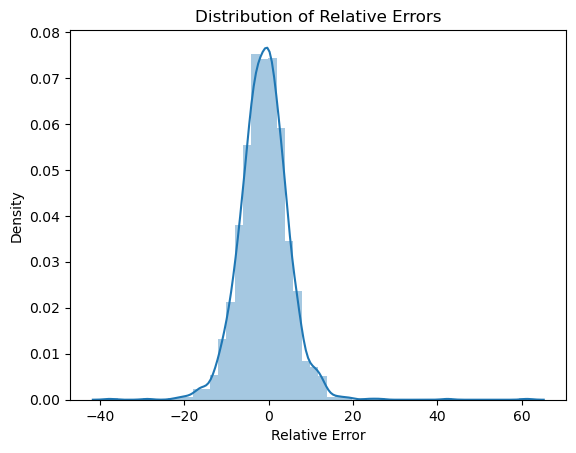

In [412]:
sns.distplot(relative_error, hist=True, kde=True)
plt.xlabel('Relative Error')
plt.title('Distribution of Relative Errors')
plt.show()

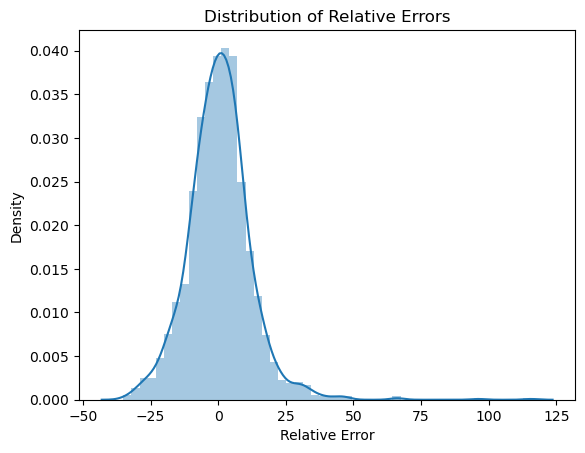

In [413]:
sns.distplot(relative_error_ct, hist=True, kde=True)
plt.xlabel('Relative Error')
plt.title('Distribution of Relative Errors')
plt.show()

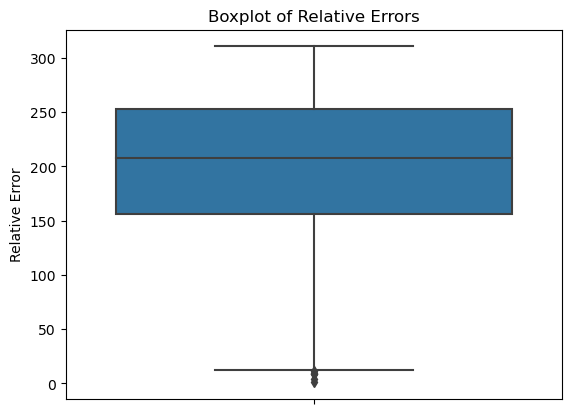

In [369]:
sns.boxplot(y=relative_error)
plt.ylabel('Relative Error')
plt.title('Boxplot of Relative Errors')
plt.show()

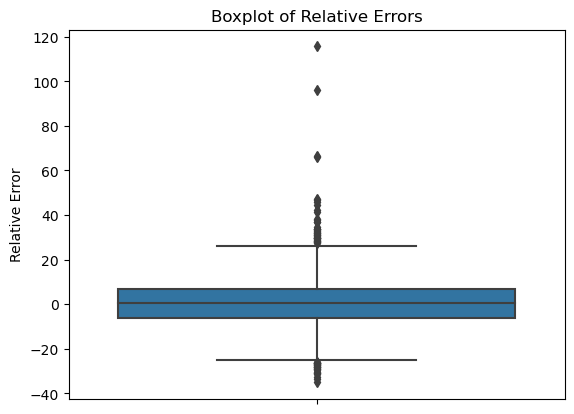

In [415]:
sns.boxplot(y=relative_error_ct)
plt.ylabel('Relative Error')
plt.title('Boxplot of Relative Errors')
plt.show()

In [416]:
Pred_Sales_df_sorted = Pred_Sales_df.sort_index()
Pred_Sales_wo_cust_df_sorted = Pred_Sales_wo_cust_df.sort_index()
Actual_Sales_df_sorted = Actual_Sales_df.sort_index()

In [417]:
Pred_Sales_df_sorted = Pred_Sales_df_sorted.resample("1D").mean()
Pred_Sales_wo_cust_df_sorted = Pred_Sales_wo_cust_df_sorted.resample("1D").mean()
Actual_Sales_df_sorted = Actual_Sales_df_sorted.resample("1D").mean()

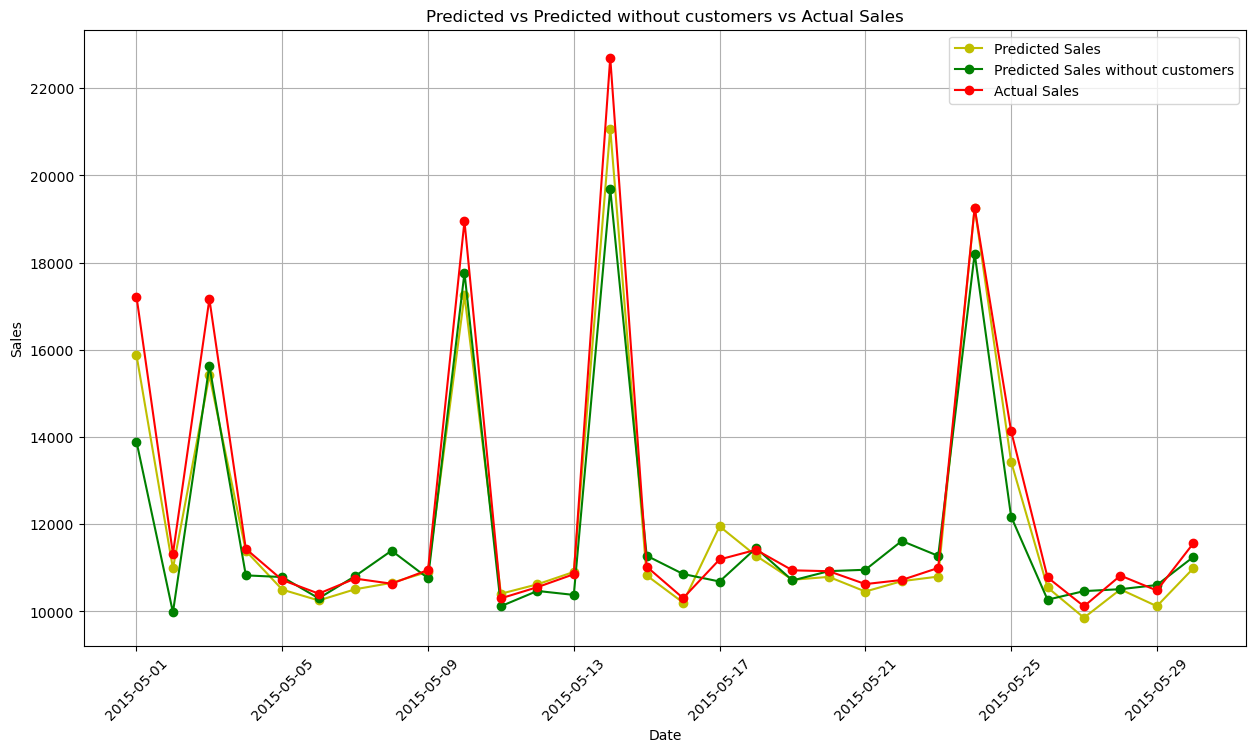

In [418]:
fig, ax = plt.subplots(figsize=(15, 8))

# Plotting Predicted Sales
ax.plot(Pred_Sales_df_sorted.index, Pred_Sales_df_sorted['Sales'], marker='o', color='y', label='Predicted Sales')

# Plotting Predicted Sales
ax.plot(Pred_Sales_wo_cust_df_sorted.index, Pred_Sales_wo_cust_df_sorted['Sales'], marker='o', color='g', label='Predicted Sales without customers')

# Plotting Actual Sales
ax.plot(Actual_Sales_df_sorted.index, Actual_Sales_df_sorted['Sales'], marker='o', color='r', label='Actual Sales')

# Setting title, labels, and legend
plt.title('Predicted vs Predicted without customers vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()